In [1]:
import random
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from copy import copy, deepcopy
from itertools import product
from tqdm import tqdm
from scipy.spatial import ConvexHull
import scipy.stats as stats


from models.game import *

sns.set_style('ticks',  {"axes.grid" : "True", "grid.color": ".4", "grid.linestyle": ":"})
sns.set_context("paper")
plt.rcParams.update({'mathtext.default':  'regular' })
plt.rcParams['xtick.direction'] = 'out'


In [2]:
N = 2
"Default number of players"

# Espaces d'action des joueurs en GtCO2


ACTION_SETS =  np.array([[[0.0, 11.47],        # China  
                         [0.0, 5.01]]]*2*T)*4       # other 

ACTION_SETS = np.swapaxes(ACTION_SETS,0,1)


r"""Default action set of the players.

References
----------

.. [1] Hannah Ritchie, Max Roser and Pablo Rosado (2020) - "CO₂ and Greenhouse Gas Emissions". Published online at OurWorldInData.org. Retrieved from: 'https://ourworldindata.org/co2-and-other-greenhouse-gas-emissions' [Online Resource]
       https://ourworldindata.org/grapher/annual-co2-emissions-per-country?facet=none&country=CHN~USA~European+Union+%2828%29~IND~RUS~Asia+%28excl.+China+and+India%29

"""

# ACTION_SETS =  np.array([[[0.0, 10.0],        # China  
#                          [0.0, 0.1],         # USA
#                          [0.0, 0.1],         # EU
#                          [0.0, 0.1],         # India
#                          [0.0, 0.1],         # Russia
#                          [0.0, 0.1]]]*T)  
# Coefficient d'impact de la temperature sur le climat 

DELTAS = np.array([1.1847,
                    1.1941])
r"""Default damage multiplier. 

References
----------

.. [1] http://www.fund-model.org/MimiFUND.jl/latest/tables/#Table-RT:-Regional-temperature-conversion-factor-1
"""



# PIB max des joueurs, j'ai pris le PIB 2020                

GDP_MAX = np.array([14.63,
                    19.29])*10


NAMES = ['China', 'USA']


In [3]:
lower_bounds = np.copy(ACTION_SETS[:,:T,:][..., 0])
upper_bounds = np.copy(ACTION_SETS[:,:T,:][..., 1])

In [4]:
from ipywidgets import interact

list_benefit_functions=BENEFITS_SIGMOID
case = 'sigmoid'
list_damage_coef = [ np.array([0,0,1.1450]), np.array([0,0,2,0])] #, np.array([0,0,0,0,1])]

def game_two_player(  r , e0, K, indice, indice_damage):
    list_players = create_players(list_benefit_functions=list_benefit_functions,  damage_function=damage_polynome(list_damage_coef[indice_damage]), discount=1)
    player = list_players[indice]
    # print(player.action_set[0])
    x = np.linspace(*player.action_set[0]*4)
    plt.plot(x, player.benefit_shape(player.GDP_max, player.action_set[0,1]*2, r=r , e=e0, K=K)(x))
    plt.plot(x, (x+1)/(x+1) * player.GDP_max)
    # print(player.benefit_shape(player.GDP_max, player.action_set[0,1], r=r , e=e0, K=K)(x) -player.GDP_max )

interact(game_two_player, r=(-1,4,0.01), e0=(-10,10,0.01), K=(-10,10,0.01), indice=(0,N-1,1), indice_damage=(0,len(list_damage_coef)-1,1))

interactive(children=(FloatSlider(value=1.0, description='r', max=4.0, min=-1.0, step=0.01), FloatSlider(value…

<function __main__.game_two_player(r, e0, K, indice, indice_damage)>

In [5]:
r = [1.15, 1.60, 2, 0.5, 1.25,0.75]
r = [ 0.2, 0.4]
e = [2, -2, -5, -4, -5, 2.5]
e = [10,-2]
horizon = 2100

X = 2020 + np.arange((horizon-2020)//5 +1 )*5

list_t_piece = np.arange(1,T,2)


list_damage_coef = [np.array([0,0,1])]#, np.array([0,0,2]) ] #np.array([0,-2,2]),  np.array([0,-0.5,1.1])] #, np.array([0,0,1.1450]), np.array([0,0,0,0,1])]
list_alpha = [1,1.5,2]
list_list_benefit_functions = [[partial(benefit_sigm, e=e[i], r = r[i]) for i in range(N)], BENEFITS_LOG]
list_label_benefit_function = [('Sigmoid', '-'), ('log', '-')]#, ('Logaritmic', 'dotted')]
# list_damage_label = [array_to_latex(coef) for coef in list_damage_coef]

case = 'sigmoid'
list_param = list(product(list_damage_coef, list_alpha, list_list_benefit_functions))
# list_label = list(product(list_damage_label, list_alpha, list_label_benefit_function))

In [6]:
list_players = create_players(alpha=2, list_action_sets=ACTION_SETS, list_of_names=NAMES, list_benefit_functions=list_list_benefit_functions[0], damage_function=damage_polynome(list_damage_coef[0]), discount=1)

game = Game(list_players, horizon=horizon)

In [7]:
a = game.get_action_space()

In [8]:
np.delete(a, (1),axis=0).shape

(1, 17, 2)

In [9]:
a.shape

(2, 17, 2)

In [10]:
game.minmax_value(1)

2182.567939055066

In [11]:
game.minmax_value(0)

1486.6283397484817

In [12]:
def generate_perturbation(action, lower_bounds=lower_bounds, upper_bounds=upper_bounds, size=5000, scale=.05):
    shape = action.shape
    perturbation = stats.norm.rvs(loc = 0, scale=scale, size=(size,*shape))
    # perturbation = truncNormal_rvs(action - lower_bounds, upper_bounds - action, loc=0, scale= scale, size=(size, *shape))
    arr = action + perturbation
    res = np.where(arr < upper_bounds, arr, upper_bounds)
    res = np.where(arr > lower_bounds, arr, lower_bounds)
    return res

In [13]:
utilities_minus = []
actions_minus = []

for idx in range(2):
    for val in np.linspace(-400,2500,50):
        res_minus = game.planning_SO_inverse_by_piece_with_constraint_return(17, constraint_player=idx, constraint_value=val)

        utilities_minus.append(np.sum(res_minus[2], axis = 1))
        actions_minus.append(res_minus[0])

        # if len(utilities)>2:
        #     if np.all(utilities[-1] == utilities[-2]):
        #         print('passed')
        #         break


Planning SO, t_piece = 17: 100%|██████████| 1/1 [00:06<00:00,  6.76s/it]


     fun: 1410.004723231344
     jac: array([-2.33752441, 49.16822815, -2.29740906, 49.23851013, -2.24578857,
       49.32894897, -2.18377686, 49.43762207, -2.1101532 , 49.56658936,
       -2.02709961, 49.71212769, -1.9344635 , 49.87442017, -1.83395386,
       50.05056763, -1.72505188, 50.24136353, -1.60736084, 50.44760132,
       -1.47909546, 50.67233276, -1.33688354, 50.92150879, -1.1776123 ,
       51.20056152, -0.99710083, 51.5168457 , -0.79011536, 51.8795166 ,
       -0.55001831, 52.30020142, -0.27389526, 52.78399658])
 message: 'Positive directional derivative for linesearch'
    nfev: 5882
     nit: 147
    njev: 143
  status: 8
 success: False
       x: array([2.41222629e+01, 5.01245921e-12, 2.42195856e+01, 4.99347114e-12,
       2.43470610e+01, 5.02963951e-12, 2.45037139e+01, 5.02942279e-12,
       2.46946817e+01, 5.02066185e-12, 2.49173450e+01, 5.03898550e-12,
       2.51755219e+01, 5.07459026e-12, 2.54684883e+01, 5.15503424e-12,
       2.58025980e+01, 5.09920332e-12, 2.61860

Planning SO, t_piece = 17: 100%|██████████| 1/1 [00:05<00:00,  5.54s/it]


     fun: 1409.1652277406815
     jac: array([-2.3510437 , 49.16473389, -2.31077576, 49.23498535, -2.25881958,
       49.32553101, -2.19644165, 49.43429565, -2.12246704, 49.56330872,
       -2.03894043, 49.7089386 , -1.94577026, 49.87136841, -1.84465027,
       50.0476532 , -1.73518372, 50.23855591, -1.61677551, 50.44497681,
       -1.48779297, 50.66989136, -1.34474182, 50.91928101, -1.18452454,
       51.19863892, -1.00292969, 51.51521301, -0.79473877, 51.87820435,
       -0.55323792, 52.29928589, -0.27552795, 52.78353882])
 message: 'Positive directional derivative for linesearch'
    nfev: 4821
     nit: 121
    njev: 117
  status: 8
 success: False
       x: array([2.41544892e+01, 2.97644381e-14, 2.42517314e+01, 2.97803358e-14,
       2.43790638e+01, 2.98427922e-14, 2.45355432e+01, 2.98862083e-14,
       2.47263475e+01, 2.99719020e-14, 2.49488238e+01, 3.00625804e-14,
       2.52067245e+01, 3.01602557e-14, 2.54994935e+01, 3.02546454e-14,
       2.58333773e+01, 3.03864165e-14, 2.6216

Planning SO, t_piece = 17: 100%|██████████| 1/1 [00:05<00:00,  5.14s/it]


     fun: 1407.9468937990246
     jac: array([-2.37039185, 49.15975952, -2.32977295, 49.2301178 , -2.27746582,
       49.32067871, -2.21459961, 49.42951965, -2.13999939, 49.5586853 ,
       -2.05581665, 49.70440674, -1.96195984, 49.86698914, -1.86001587,
       50.04345703, -1.74961853, 50.23460388, -1.63027954, 50.44122314,
       -1.50021362, 50.66641235, -1.35598755, 50.9161377 , -1.19444275,
       51.1958313 , -1.01135254, 51.51286316, -0.80142212, 51.87634277,
       -0.55786133, 52.29800415, -0.27783203, 52.78291321])
 message: 'Positive directional derivative for linesearch'
    nfev: 3928
     nit: 99
    njev: 95
  status: 8
 success: False
       x: array([2.42009354e+01, 7.35590227e-14, 2.42980510e+01, 7.35938882e-14,
       2.44251692e+01, 7.33923856e-14, 2.45814184e+01, 7.37419774e-14,
       2.47719598e+01, 7.39334097e-14, 2.49941220e+01, 7.42339577e-14,
       2.52517375e+01, 7.39885739e-14, 2.55441829e+01, 7.43862943e-14,
       2.58777469e+01, 7.48634000e-14, 2.626060

Planning SO, t_piece = 17: 100%|██████████| 1/1 [00:05<00:00,  5.31s/it]


     fun: 1406.8768164631974
     jac: array([-2.38726807, 49.15533447, -2.34634399, 49.22576904, -2.29371643,
       49.31634521, -2.2303772 , 49.42532349, -2.15531921, 49.55453491,
       -2.0705719 , 49.70037842, -1.9760437 , 49.86309814, -1.87339783,
       50.03973389, -1.76220703, 50.23106384, -1.64202881, 50.43792725,
       -1.51104736, 50.6633606 , -1.36578369, 50.9133606 , -1.20309448,
       51.19335938, -1.0186615 , 51.51074219, -0.80722046, 51.87469482,
       -0.56188965, 52.29684448, -0.27983093, 52.78231812])
 message: 'Positive directional derivative for linesearch'
    nfev: 4412
     nit: 114
    njev: 110
  status: 8
 success: False
       x: array([2.42414388e+01, 2.20325437e-15, 2.43384226e+01, 2.25458355e-15,
       2.44653745e+01, 2.22890063e-15, 2.46213587e+01, 2.29741483e-15,
       2.48116842e+01, 2.18859608e-15, 2.50336599e+01, 2.26628991e-15,
       2.52909826e+01, 2.26479194e-15, 2.55831472e+01, 2.26471304e-15,
       2.59163898e+01, 2.28674492e-15, 2.6299

Planning SO, t_piece = 17: 100%|██████████| 1/1 [00:04<00:00,  4.69s/it]


     fun: 1405.8679704338138
     jac: array([-2.40292358, 49.15129089, -2.36172485, 49.22175598, -2.30874634,
       49.31242371, -2.24507141, 49.42140198, -2.16954041, 49.5506897 ,
       -2.08424377, 49.69668579, -1.98907471, 49.85955811, -1.885849  ,
       50.0362854 , -1.77391052, 50.22779846, -1.65293884, 50.43489075,
       -1.52111816, 50.66052246, -1.37486267, 50.91079712, -1.21107483,
       51.19111633, -1.02542114, 51.50888062, -0.81256104, 51.87319946,
       -0.56564331, 52.29579163, -0.28167725, 52.78181458])
 message: 'Positive directional derivative for linesearch'
    nfev: 3108
     nit: 82
    njev: 78
  status: 8
 success: False
       x: array([2.42792908e+01, 2.50408069e-12, 2.43761404e+01, 2.50778287e-12,
       2.45029818e+01, 2.51219290e-12, 2.46588179e+01, 2.51762603e-12,
       2.48489138e+01, 2.52458156e-12, 2.50705916e+01, 2.53146283e-12,
       2.53276969e+01, 2.53952869e-12, 2.56196245e+01, 2.54918269e-12,
       2.59526306e+01, 2.55911443e-12, 2.633494

Planning SO, t_piece = 17: 100%|██████████| 1/1 [00:04<00:00,  4.43s/it]


     fun: 1404.6429623017582
     jac: array([-2.42173767, 49.14631653, -2.38023376, 49.21687317, -2.32685852,
       49.30763245, -2.26271057, 49.41667175, -2.18659973, 49.54614258,
       -2.10066223, 49.69218445, -2.00482178, 49.85517883, -1.90075684,
       50.03215027, -1.78799438, 50.22386169, -1.6660614 , 50.4311676 ,
       -1.53318787, 50.65708923, -1.38580322, 50.90766907, -1.22073364,
       51.18833923, -1.03359985, 51.5065155 , -0.81906128, 51.87132263,
       -0.57017517, 52.29450989, -0.28393555, 52.78117371])
 message: 'Positive directional derivative for linesearch'
    nfev: 3305
     nit: 86
    njev: 82
  status: 8
 success: False
       x: array([2.43249543e+01, 2.20782539e-11, 2.44216613e+01, 2.22383472e-11,
       2.45483239e+01, 2.21410169e-11, 2.47039336e+01, 2.22432436e-11,
       2.48937703e+01, 2.22899521e-11, 2.51151419e+01, 2.21211700e-11,
       2.53719660e+01, 2.23208232e-11, 2.56635776e+01, 2.24947474e-11,
       2.59962786e+01, 2.25164057e-11, 2.637826

Planning SO, t_piece = 17: 100%|██████████| 1/1 [00:03<00:00,  3.65s/it]


     fun: 1403.4818725383755
     jac: array([-2.43934631, 49.14164734, -2.39759827, 49.2122345 , -2.34385681,
       49.30303955, -2.2792511 , 49.41220093, -2.20259094, 49.54176331,
       -2.11608887, 49.6879425 , -2.01954651, 49.85108948, -1.91473389,
       50.02818298, -1.80119324, 50.22010803, -1.6783905 , 50.42762756,
       -1.54447937, 50.65386963, -1.39605713, 50.90470886, -1.22976685,
       51.1857605 , -1.04127502, 51.50428772, -0.82511902, 51.86956787,
       -0.5743866 , 52.29328918, -0.286026  , 52.78056335])
 message: 'Positive directional derivative for linesearch'
    nfev: 2894
     nit: 77
    njev: 73
  status: 8
 success: False
       x: array([2.43678821e+01, 5.58506820e-13, 2.44644750e+01, 5.59215128e-13,
       2.45909318e+01, 5.60814770e-13, 2.47463573e+01, 5.61757113e-13,
       2.49359519e+01, 5.63603892e-13, 2.51571249e+01, 5.65051207e-13,
       2.54136169e+01, 5.67017127e-13, 2.57049211e+01, 5.68502787e-13,
       2.60373559e+01, 5.71110622e-13, 2.641904

Planning SO, t_piece = 17: 100%|██████████| 1/1 [00:02<00:00,  2.70s/it]


     fun: 1402.285151824662
     jac: array([-2.45724487, 49.13691711, -2.41516113, 49.20761108, -2.36105347,
       49.29844666, -2.29603577, 49.40768433, -2.21881104, 49.53735352,
       -2.13171387, 49.68362427, -2.03450012, 49.84690857, -1.92892456,
       50.02423096, -1.81455994, 50.21632385, -1.69087219, 50.42407227,
       -1.55599976, 50.65057373, -1.40647888, 50.90170288, -1.23892212,
       51.18310547, -1.04901123, 51.5020752 , -0.83125305, 51.86776733,
       -0.57865906, 52.29203796, -0.28814697, 52.779953  ])
 message: 'Positive directional derivative for linesearch'
    nfev: 2052
     nit: 57
    njev: 53
  status: 8
 success: False
       x: array([2.44117905e+01, 2.63868665e-11, 2.45082849e+01, 2.64175004e-11,
       2.46345498e+01, 2.64657362e-11, 2.47897633e+01, 2.65181336e-11,
       2.49791046e+01, 2.65821193e-11, 2.51999977e+01, 2.66543991e-11,
       2.54562444e+01, 2.67270348e-11, 2.57472565e+01, 2.68189367e-11,
       2.60793656e+01, 2.69049602e-11, 2.6460765

Planning SO, t_piece = 17: 100%|██████████| 1/1 [00:02<00:00,  2.75s/it]


     fun: 1401.051875312051
     jac: array([-2.47543335, 49.13208008, -2.43307495, 49.20278931, -2.37858582,
       49.29373169, -2.31307983, 49.40306091, -2.23538208, 49.53279114,
       -2.14764404, 49.679245  , -2.04968262, 49.8427124 , -1.94337463,
       50.02017212, -1.828125  , 50.2124939 , -1.70353699, 50.42047119,
       -1.56770325, 50.6472168 , -1.41702271, 50.8986969 , -1.24822998,
       51.18045044, -1.05686951, 51.49981689, -0.8374939 , 51.86602783,
       -0.58297729, 52.29083252, -0.29029846, 52.77935791])
 message: 'Positive directional derivative for linesearch'
    nfev: 1892
     nit: 53
    njev: 49
  status: 8
 success: False
       x: array([2.44567035e+01, 1.17907767e-11, 2.45530493e+01, 1.18105651e-11,
       2.46791544e+01, 1.18258443e-11, 2.48341753e+01, 1.18652989e-11,
       2.50232542e+01, 1.18907152e-11, 2.52438709e+01, 1.19221134e-11,
       2.54998018e+01, 1.19646886e-11, 2.57905673e+01, 1.20087993e-11,
       2.61223379e+01, 1.20527517e-11, 2.6503429

Planning SO, t_piece = 17: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it]


     fun: 1399.7896668532526
     jac: array([-2.49383545, 49.12715149, -2.45115662, 49.19792175, -2.39631653,
       49.28894043, -2.33035278, 49.39831543, -2.2520752 , 49.52816772,
       -2.16375732, 49.67474365, -2.06509399, 49.83834839, -1.95797729,
       50.01602173, -1.8419342 , 50.20851135, -1.71638489, 50.41677856,
       -1.57952881, 50.64379883, -1.42776489, 50.89556885, -1.25767517,
       51.17770386, -1.06488037, 51.49746704, -0.84385681, 51.86416626,
       -0.58740234, 52.28952026, -0.29249573, 52.77870178])
 message: 'Positive directional derivative for linesearch'
    nfev: 1838
     nit: 51
    njev: 47
  status: 8
 success: False
       x: array([2.45023133e+01, 2.71302336e-15, 2.45985143e+01, 2.74094498e-15,
       2.47244625e+01, 2.74476941e-15, 2.48792460e+01, 2.74255455e-15,
       2.50680977e+01, 2.75431837e-15, 2.52884449e+01, 2.76716028e-15,
       2.55441003e+01, 2.77515547e-15, 2.58345276e+01, 2.78869121e-15,
       2.61660139e+01, 2.79167798e-15, 2.654677

Planning SO, t_piece = 17: 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


     fun: -184.67479193528231
     jac: array([ 1.93322563, 51.24060631,  1.98264313, 51.75565147,  2.04571533,
       51.81872177,  2.11778259, 51.89078522,  2.19855881, 51.97156906,
        2.28370285, 52.05670929,  2.37223625, 52.14524078,  2.46115685,
       52.23416138,  2.55006218, 52.32306862,  2.63856506, 52.41157532,
        2.72744179, 52.5004406 ,  2.81878281, 52.59178543,  2.91400146,
       52.6870079 ,  3.01481628, 52.78783035,  3.12311554, 52.89612198,
        3.24110413, 53.01411057,  3.36929703, 53.1423111 ])
 message: 'Positive directional derivative for linesearch'
    nfev: 230
     nit: 10
    njev: 6
  status: 8
 success: False
       x: array([1.60629112e-10, 5.70421589e-02, 1.49053785e-10, 6.48608908e-09,
       1.49135200e-10, 2.51639407e-09, 1.49658139e-10, 2.51737885e-09,
       1.49281762e-10, 2.51658536e-09, 1.51718899e-10, 2.51846989e-09,
       1.51439053e-10, 2.51868243e-09, 1.52494230e-10, 2.51983723e-09,
       1.54344222e-10, 2.52162258e-09, 1.5731140

Planning SO, t_piece = 17: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


     fun: 94.71325631411914
     jac: array([ 1.7353344 , -1.7186451 ,  1.79087067, 21.57878113,  1.86398315,
       51.63699341,  1.94698811, 51.71999454,  2.03898239, 51.81198883,
        2.1353178 , 51.90833187,  2.23503876, 52.00804424,  2.33501148,
       52.10801792,  2.43488407, 52.20788574,  2.53430367, 52.30731392,
        2.6341486 , 52.40715504,  2.73673916, 52.50975323,  2.84363556,
       52.61664104,  2.95677757, 52.72978401,  3.07828236, 52.85128498,
        3.21064758, 52.98365307,  3.35445786, 53.12746334])
 message: 'Positive directional derivative for linesearch'
    nfev: 668
     nit: 23
    njev: 19
  status: 8
 success: False
       x: array([1.23451176e-10, 2.00400000e+01, 1.28984672e-10, 3.37357018e+00,
       1.26395231e-10, 1.77607894e-08, 1.22533092e-10, 9.07500916e-09,
       1.17933368e-10, 8.19240558e-10, 1.14004172e-10, 1.04898617e-09,
       1.09328548e-10, 1.04439322e-09, 1.06135340e-10, 1.04115548e-09,
       1.02861627e-10, 1.03783188e-09, 9.84496217

Planning SO, t_piece = 17: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


     fun: 199.23182414142514
     jac: array([ 1.58081055, -1.87316704,  1.63645554, -1.81750679,  1.71571541,
       37.24351692,  1.80768013, 51.58068657,  1.90916252, 51.68217087,
        2.01487923, 51.78788948,  2.1238842 , 51.89688683,  2.23295593,
       52.00596237,  2.34181976, 52.1148262 ,  2.45015144, 52.22315598,
        2.55893135, 52.3319416 ,  2.67066193, 52.44366455,  2.78702354,
       52.56002998,  2.91012192, 52.68312454,  3.04227448, 52.81528091,
        3.186203  , 52.95920944,  3.34255791, 53.11556435])
 message: 'Positive directional derivative for linesearch'
    nfev: 700
     nit: 24
    njev: 20
  status: 8
 success: False
       x: array([ 0.        , 20.04      ,  0.        , 20.03999999,  0.        ,
        1.55177587,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        

Planning SO, t_piece = 17: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


     fun: 1003.6934024035838
     jac: array([ 0.81161499, -2.6423645 ,  0.86503601, -2.58893585,  0.94090271,
       -2.51309967,  1.0366745 , -2.41732025,  1.15406036, -2.29992676,
        1.28939819, -2.1645813 ,  1.44261169, -2.01137543,  1.60752869,
       51.38053131,  1.77378845, 51.54678345,  1.93810272, 51.71108246,
        2.10229492, 28.59298706,  2.27114105, 52.04415131,  2.44631195,
       52.2193222 ,  2.63058472, 52.40359497,  2.82736969, 52.60036469,
        3.04083252, 52.81384277,  3.27198792, 53.04499817])
 message: 'Positive directional derivative for linesearch'
    nfev: 770
     nit: 26
    njev: 22
  status: 8
 success: False
       x: array([0.00000000e+00, 2.00400000e+01, 3.15985337e-12, 2.00400000e+01,
       3.37833140e-12, 2.00400000e+01, 3.69930861e-12, 2.00400000e+01,
       4.07554766e-12, 2.00400000e+01, 4.44689713e-12, 2.00400000e+01,
       5.00206260e-12, 2.00400000e+01, 5.65449429e-12, 0.00000000e+00,
       6.24413140e-12, 1.65847733e-10, 6.8835253

Planning SO, t_piece = 17: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


     fun: 1060.8572045667509
     jac: array([ 0.79527283, -2.65867615,  0.84884644, -2.60508728,  0.92478943,
       -2.52914429,  1.02062988, -2.43330383,  1.13801575, -2.31591797,
        1.27330017, -2.18066406,  1.42637634, -2.02763367,  1.59104919,
       51.36404419,  1.75697327, 51.529953  ,  1.92085266, 51.69386292,
        2.08509827,  8.29881287,  2.25584412, 52.02883911,  2.43347168,
       52.20646667,  2.62017822, 52.39318848,  2.81947327, 52.59248352,
        3.03553772, 52.80854797,  3.26947021, 53.04246521])
 message: 'Positive directional derivative for linesearch'
    nfev: 915
     nit: 29
    njev: 25
  status: 8
 success: False
       x: array([1.32918420e-12, 2.00400000e+01, 2.81919423e-11, 2.00400000e+01,
       3.69023879e-12, 2.00400000e+01, 4.99533905e-12, 2.00400000e+01,
       4.59234617e-12, 2.00400000e+01, 2.17935136e-11, 2.00400000e+01,
       4.56071634e-12, 2.00400000e+01, 1.29058557e-10, 5.46292836e-11,
       2.85590218e-11, 6.27776749e-11, 1.0556144

Planning SO, t_piece = 17: 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


     fun: 2095.303877566019
     jac: array([ 0.15795898, -3.29598999,  0.21795654, -3.23599243,  0.29824829,
       -3.15567017,  0.39614868, -3.05776978,  0.51318359, -2.94073486,
        0.64529419, -2.80865479,  0.79226685, -2.66165161,  0.95101929,
       -2.50286865,  1.12188721, -2.33203125,  1.30526733, -2.14862061,
        1.50360107, -1.9503479 ,  1.72192383, -1.73196411,  1.9642334 ,
       -1.48968506,  2.23190308, 40.21417236,  2.51922607, 52.29223633,
        2.828125  , 52.60113525,  3.16339111, -0.29058838])
 message: 'Positive directional derivative for linesearch'
    nfev: 985
     nit: 31
    njev: 27
  status: 8
 success: False
       x: array([3.39253938e-15, 2.00400000e+01, 0.00000000e+00, 2.00400000e+01,
       0.00000000e+00, 2.00400000e+01, 9.16764290e-14, 2.00400000e+01,
       0.00000000e+00, 2.00400000e+01, 0.00000000e+00, 2.00400000e+01,
       0.00000000e+00, 2.00400000e+01, 0.00000000e+00, 2.00400000e+01,
       0.00000000e+00, 2.00400000e+01, 4.06216179

Planning SO, t_piece = 17: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


In [14]:
arr_minus = np.array(utilities_minus)
arr_actions_minus = np.stack(actions_minus,axis=0)


In [15]:
minus_perturbated = np.concatenate([np.concatenate([generate_perturbation(minus, lower_bounds, upper_bounds, scale=scale) for scale in [0.05, 0.15, 0.5, 1, 1.5]]) for minus in arr_actions_minus])

In [16]:
def process(list_strategy_profile, game : Game) : 
    data_utilities = []
    data_temp = []
    list_sum_strategy = np.sum(list_strategy_profile, axis=1)
    list_ = list(zip(list_strategy_profile,list_sum_strategy))
    for strategy, sum_ in tqdm(list_, total = len(list_), desc ='Processing'):
        u,temp = game.game_with_strategies_profile(strategy,sum_)
        data_utilities.append(u)
        data_temp.append(temp)
    return np.array(data_utilities), np.array(data_temp)

In [17]:
utilities = []
for idx in range(2):
    for val in np.linspace(-300,3500,50):
        res = game.planning_SO_by_piece_with_constraint_return(17, constraint_player=idx, constraint_value=val)
        utilities.append(np.sum(res[2], axis=1))

arr = np.array(utilities)


Planning SO, t_piece = 17: 100%|██████████| 1/1 [00:04<00:00,  4.94s/it]


     fun: -2646.3061394662345
     jac: array([  2.30432129, -48.99633789,   2.26477051, -48.15539551,
         2.21435547, -47.08328247,   2.15414429, -45.80358887,
         2.08300781, -44.29019165,   2.00286865, -42.58572388,
         1.91351318, -40.68591309,   1.81646729, -38.62283325,
         1.71121216, -36.38479614,   1.59713745, -33.95932007,
         1.47247314, -31.30770874,   1.33364868, -28.35675049,
         1.1774292 , -25.03546143,   0.99957275, -21.25268555,
         0.79431152, -16.88894653,   0.55462646, -11.79260254,
         0.27703857,  -5.89093018])
 message: 'Positive directional derivative for linesearch'
    nfev: 3809
     nit: 110
    njev: 106
  status: 8
 success: False
       x: array([2.37370516e+01, 1.00187181e-02, 2.38353800e+01, 1.20694138e-01,
       2.39627926e+01, 2.57378927e-01, 2.41183119e+01, 4.15395950e-01,
       2.43071028e+01, 5.96797672e-01, 2.45265786e+01, 7.96047911e-01,
       2.47804821e+01, 1.01405587e+00, 2.50683842e+01, 1.24830519e+

Planning SO, t_piece = 17: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


In [18]:
argsort = arr[:,0].argsort()

sorted = np.zeros_like(arr)
sorted[:,0] = arr[:,0][argsort]
sorted[:,1] = arr[:,1][argsort]


argsort = arr_minus[:,0].argsort()

sorted_minus = np.zeros_like(arr_minus)
sorted_minus[:,0] = arr_minus[:,0][argsort]
sorted_minus[:,1] = arr_minus[:,1][argsort]

In [19]:
ir_0 = game.minmax_value(0)
ir_1 = game.minmax_value(1)

In [ ]:
print(ir_0, ir_1)

1486.6283397484817 2182.567939055066

In [25]:
x = np.linspace(np.min(sorted[:,0]), np.max(sorted[:,0]),100)
y = np.linspace(np.min(sorted[:,1]), np.max(sorted[:,1]),100)

In [21]:
game.reset()
a_rece, sum_a_rece, u_rece, sum_u_rece, temp_rece = game.receding_BRD_by_piece_return(17)
game.reset()
a_plan, sum_a_plan, u_plan, sum_u_plan, temp_plan = game.planning_BRD_by_piece_return(17)

game.reset()
a_plan_so, sum_a_plan_so, u_plan_so, sum_u_plan_so, temp_plan_so = game.planning_SO_by_piece_return(17)
game.reset()
a_rece_so, sum_a_rece_so, u_rece_so, sum_u_rece_so, temp_rece_so = game.receding_SO_by_piece_return(17)

u_p = np.sum(u_plan, axis=1)
u_r = np.sum(u_rece, axis=1)
u_p_so = np.sum(u_plan_so, axis =1)
u_r_so = np.sum(u_rece_so, axis =1)

Planning SO, t_piece = 17:   0%|          | 0/1 [00:00<?, ?it/s]

SO SLSQP 0.4901747703552246


Planning SO, t_piece = 17: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


SO L-BFGS-B: 0.37480664253234863


Receding SO, t_piece = 17:   0%|          | 0/17 [00:00<?, ?it/s]

SO SLSQP 0.3666858673095703


Receding SO, t_piece = 17:   6%|▌         | 1/17 [00:00<00:09,  1.61it/s]

SO L-BFGS-B: 0.2559490203857422
SO SLSQP 0.4685966968536377


Receding SO, t_piece = 17:  12%|█▏        | 2/17 [00:01<00:12,  1.16it/s]

SO L-BFGS-B: 0.554283618927002
SO SLSQP 0.42998552322387695


Receding SO, t_piece = 17:  18%|█▊        | 3/17 [00:02<00:11,  1.22it/s]

SO L-BFGS-B: 0.34827184677124023
SO SLSQP 0.3971731662750244


Receding SO, t_piece = 17:  24%|██▎       | 4/17 [00:03<00:10,  1.26it/s]

SO L-BFGS-B: 0.34322261810302734
SO SLSQP 0.46219730377197266


Receding SO, t_piece = 17:  29%|██▉       | 5/17 [00:04<00:09,  1.21it/s]

SO L-BFGS-B: 0.4163694381713867
SO SLSQP 0.4361274242401123


Receding SO, t_piece = 17:  35%|███▌      | 6/17 [00:04<00:08,  1.26it/s]

SO L-BFGS-B: 0.2939023971557617
SO SLSQP 0.4655425548553467


Receding SO, t_piece = 17:  41%|████      | 7/17 [00:05<00:07,  1.28it/s]

SO L-BFGS-B: 0.2924785614013672
SO SLSQP 0.5217039585113525


Receding SO, t_piece = 17:  47%|████▋     | 8/17 [00:06<00:07,  1.22it/s]

SO L-BFGS-B: 0.3853633403778076
SO SLSQP 0.43189358711242676


Receding SO, t_piece = 17:  53%|█████▎    | 9/17 [00:07<00:06,  1.24it/s]

SO L-BFGS-B: 0.33469676971435547
SO SLSQP 0.4690675735473633


Receding SO, t_piece = 17:  59%|█████▉    | 10/17 [00:08<00:05,  1.21it/s]

SO L-BFGS-B: 0.394350528717041
SO SLSQP 0.6226544380187988


Receding SO, t_piece = 17:  65%|██████▍   | 11/17 [00:09<00:05,  1.03it/s]

SO L-BFGS-B: 0.679649829864502
SO SLSQP 0.9627676010131836


Receding SO, t_piece = 17:  71%|███████   | 12/17 [00:11<00:05,  1.18s/it]

SO L-BFGS-B: 0.7033283710479736
SO SLSQP 0.6380164623260498


Receding SO, t_piece = 17:  76%|███████▋  | 13/17 [00:12<00:04,  1.22s/it]

SO L-BFGS-B: 0.674370527267456
SO SLSQP 0.66943359375


Receding SO, t_piece = 17:  82%|████████▏ | 14/17 [00:13<00:03,  1.20s/it]

SO L-BFGS-B: 0.48090672492980957
SO SLSQP 0.5458037853240967


Receding SO, t_piece = 17:  88%|████████▊ | 15/17 [00:14<00:02,  1.14s/it]

SO L-BFGS-B: 0.4371652603149414
SO SLSQP 0.6421620845794678


Receding SO, t_piece = 17:  94%|█████████▍| 16/17 [00:15<00:01,  1.17s/it]

SO L-BFGS-B: 0.6204919815063477
SO SLSQP 0.6845245361328125


Receding SO, t_piece = 17: 100%|██████████| 17/17 [00:17<00:00,  1.01s/it]

SO L-BFGS-B: 0.7991001605987549


In [51]:
inter = np.interp(x, sorted[:,0], sorted[:,1])

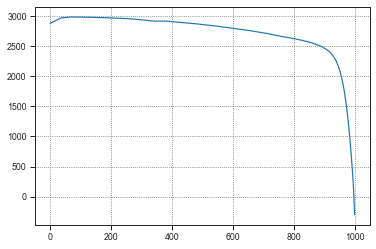

In [52]:
plt.plot(inter)

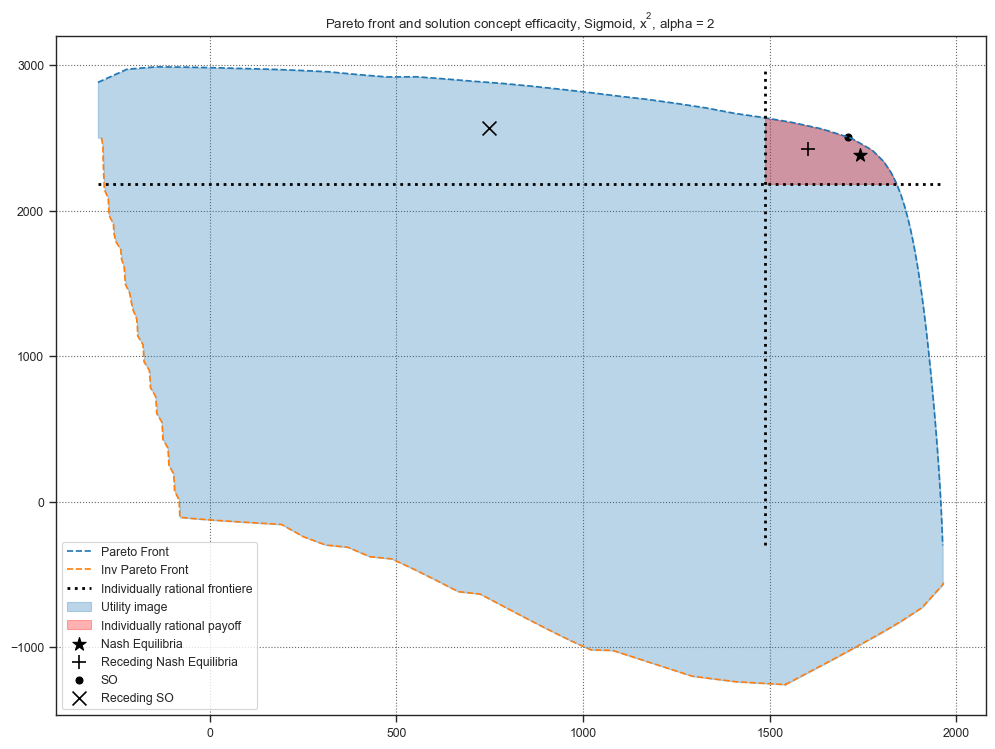

In [70]:
plt.figure( dpi=100, figsize=(12,9))
x = np.linspace(np.min(sorted[:,0]), np.max(sorted[:,0]),1000)

inter = np.interp(x, sorted[:,0], sorted[:,1])
inter_minus = np.interp(x, sorted_minus[:,0], sorted_minus[:,1])


# plt.scatter(arr[:,0], arr[:,1], label='Pareto Front')
# plt.scatter(arr_minus[:,0], arr_minus[:,1], label='Inv Pareto Front')
plt.plot(sorted[:,0], sorted[:,1], ls='--', label='Pareto Front')
plt.plot(sorted_minus[:,0], sorted_minus[:,1], ls='--', label='Inv Pareto Front')
# plt.plot(x, inter)
plt.plot(x, np.ones_like(x)* ir_1,lw=2,ls='dotted', color='black', label='Individually rational frontiere')
plt.plot(np.ones_like(y)* ir_0,y ,lw=2,ls='dotted', color='black')
plt.fill_between(x, inter, inter_minus, alpha=0.3, label='Utility image', color='C0')
plt.fill_between(x, ir_1,inter, where=((x >= ir_0 *np.ones_like(x))  * (inter > ir_1 * np.ones_like(x))), label='Individually rational payoff', color='red', alpha=0.3)
# plt.scatter(u_minus[:,0], u_minus[:,1], c=u_minus_temp[:,16])

plt.scatter(u_p[0], u_p[1], marker='*', c='black', s=100, label='Nash Equilibria')
plt.scatter(u_r[0], u_r[1], marker='+', c='black',s=100, label='Receding Nash Equilibria')
plt.scatter(u_p_so[0], u_p_so[1], marker='.',c='black', s=100, label='SO')
plt.scatter(u_r_so[0], u_r_so[1], marker='x',c='black', s=100, label='Receding SO')
plt.title('Pareto front and solution concept efficacity, Sigmoid, $x^2$, alpha = 2')
plt.legend()
plt.show()

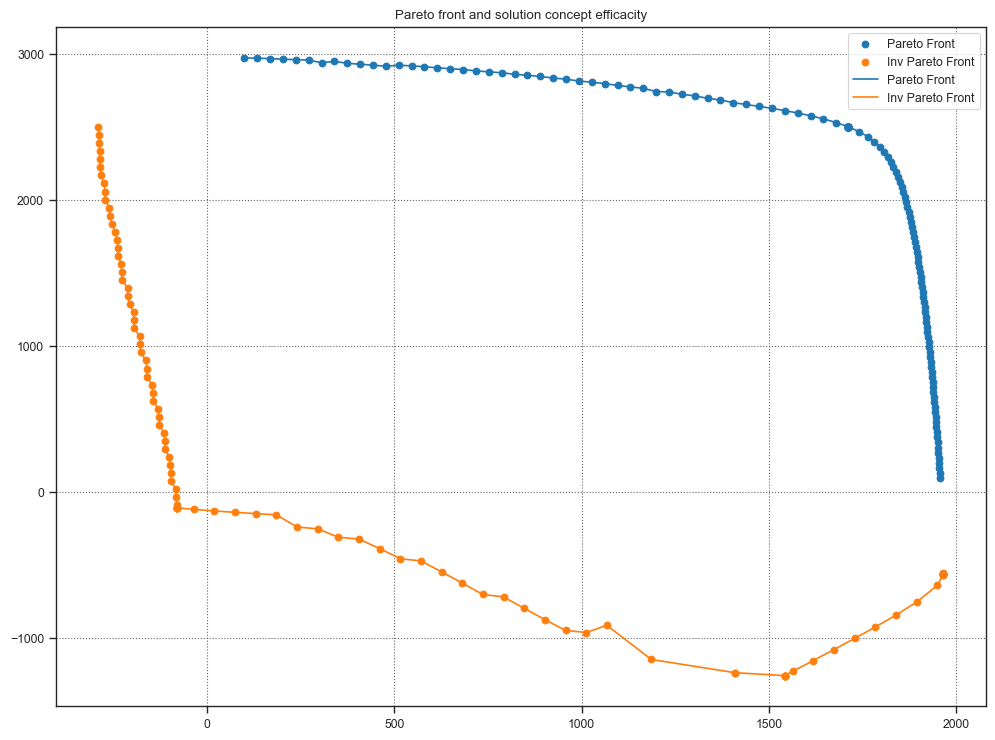

In [ ]:
plt.figure( dpi=100, figsize=(12,9))
plt.scatter(arr[:,0], arr[:,1], label='Pareto Front')
plt.scatter(arr_minus[:,0], arr_minus[:,1], label='Inv Pareto Front')
plt.plot(sorted[:,0], sorted[:,1], label='Pareto Front')
plt.plot(sorted_minus[:,0], sorted_minus[:,1], label='Inv Pareto Front')


# plt.scatter(u_minus[:,0], u_minus[:,1], c=u_minus_temp[:,16])

# plt.scatter(u_p[0], u_p[1], marker='*', c='black', s=100, label='Nash Equilibria')
# plt.scatter(u_r[0], u_r[1], marker='+', c='black',s=100, label='Receding Nash Equilibria')
# plt.scatter(u_p_so[0], u_p_so[1], marker='.',c='black', s=100, label='SO')
# plt.scatter(u_r_so[0], u_r_so[1], marker='x',c='black', s=100, label='Receding SO')
plt.title('Pareto front and solution concept efficacity')
plt.legend()
plt.show()

In [50]:
if np.all(utilities[-1] == utilities[-2]):
    print('ok')

ok


In [42]:
arr

array([[  99.99999991, 2974.79852895],
       [ 169.38775457, 2969.82392012],
       [ 238.77550874, 2962.70669151],
       [ 308.1632659 , 2944.75948449],
       [ 377.55101962, 2937.02819109],
       [ 446.93877525, 2924.47544504],
       [ 516.32653002, 2924.0952237 ],
       [ 585.71428441, 2913.68352979],
       [ 655.10203877, 2899.94460218],
       [ 724.48979553, 2884.65512055],
       [ 793.87755082, 2871.00598529],
       [ 863.26530593, 2853.7771945 ],
       [ 932.65306014, 2834.83641781],
       [1002.04081619, 2814.24667051],
       [1071.42857089, 2796.20683405],
       [1140.81632624, 2773.21633894],
       [1210.20408042, 2736.27935616],
       [1279.59183634, 2721.76845443],
       [1348.97958981, 2693.34831656],
       [1418.36734667, 2663.13517473],
       [1487.75510163, 2637.07375006],
       [1557.14285675, 2606.71096327],
       [1626.5306117 , 2569.16075359],
       [1695.9183666 , 2517.89314178],
       [1709.94776888, 2504.57813712],
       [1709.94776888, 25

In [ ]:
utilities = []
for idx in range(2):
    for val in np.linspace(100,3500,100):
        res = game.planning_SO_by_piece_with_constraint_return(17, constraint_player=idx, constraint_value=val)
        utilities.append(np.sum(res[2], axis=1))
        if len(utilities)>2:
            if np.all(utilities[-1] == utilities[-2]):
                print('passed')
                break


Planning SO, t_piece = 17: 100%|██████████| 1/1 [00:03<00:00,  3.22s/it]


passed


Planning SO, t_piece = 17: 100%|██████████| 1/1 [00:21<00:00, 21.17s/it]


     fun: -2622.8375177084126
     jac: array([  2.30322266, -49.08126831,   2.26367188, -48.65533447,
         2.21325684, -47.57351685,   2.15307617, -46.27929688,
         2.08190918, -44.74990845,   2.00177002, -43.02719116,
         1.91247559, -41.10757446,   1.81549072, -39.02374268,
         1.71026611, -36.76190186,   1.59625244, -34.31149292,
         1.47164917, -31.63259888,   1.33294678, -28.65075684,
         1.17684937, -25.29547119,   0.99899292, -21.47247314,
         0.79388428, -17.0630188 ,   0.55432129, -11.9151001 ,
         0.27685547,  -5.95214844])
 message: 'Positive directional derivative for linesearch'
    nfev: 3589
     nit: 104
    njev: 100
  status: 8
 success: False
       x: array([2.37449610e+01, 1.12412444e-07, 2.38433736e+01, 6.09492888e-02,
       2.39707382e+01, 2.00763919e-01, 2.41263640e+01, 3.62233704e-01,
       2.43151488e+01, 5.46917038e-01, 2.45345112e+01, 7.49250302e-01,
       2.47884551e+01, 9.70069692e-01, 2.50763143e+01, 1.20678171e+

Planning SO, t_piece = 17: 100%|██████████| 1/1 [00:03<00:00,  3.36s/it]


     fun: -3084.7553749533868
     jac: array([  2.32476807, -39.21194458,   2.2850647 , -38.54196167,
         2.23446655, -37.6880188 ,   2.17404175, -36.66934204,
         2.10247803, -35.46237183,   2.0218811 , -34.10263062,
         1.93179321, -32.5843811 ,   1.83395386, -30.93313599,
         1.72769165, -29.13983154,   1.61242676, -27.19723511,
         1.48635864, -25.07385254,   1.34613037, -22.70846558,
         1.18838501, -20.04598999,   1.00878906, -17.01382446,
         0.80130005, -13.51730347,   0.55947876,  -9.43832397,
         0.27935791,  -4.71255493])
 message: 'Positive directional derivative for linesearch'
    nfev: 2969
     nit: 87
    njev: 83
  status: 8
 success: False
       x: array([23.5656983 ,  1.08598848, 23.6638746 ,  1.16367354, 23.79109094,
        1.26251081, 23.94648649,  1.38038443, 24.1352681 ,  1.52030202,
       24.35496568,  1.67877404, 24.60922522,  1.8574399 , 24.89786097,
        2.05470951, 25.22702814,  2.27362772, 25.60497955,  2.5179

Planning SO, t_piece = 17: 100%|██████████| 1/1 [00:10<00:00, 10.89s/it]


     fun: -3183.0337291353467
     jac: array([  2.32791138, -36.70736694,   2.28817749, -36.08120728,
         2.2376709 , -35.28323364,   2.17721558, -34.33117676,
         2.10562134, -33.20193481,   2.02493286, -31.92984009,
         1.93484497, -30.50930786,   1.83688354, -28.96347046,
         1.73046875, -27.28689575,   1.61508179, -25.46740723,
         1.48886108, -23.47717285,   1.34841919, -21.26150513,
         1.1902771 , -18.76818848,   1.01019287, -15.92892456,
         0.80252075, -12.65509033,   0.56021118,  -8.83395386,
         0.27975464,  -4.41043091])
 message: 'Positive directional derivative for linesearch'
    nfev: 3194
     nit: 93
    njev: 89
  status: 8
 success: False
       x: array([23.51714629,  1.34550477, 23.61529857,  1.41851612, 23.74259095,
        1.51169578, 23.89797745,  1.62330119, 24.08669482,  1.75645172,
       24.30641223,  1.90792326, 24.56084983,  2.07945565, 24.84970028,
        2.26974761, 25.17916877,  2.48153454, 25.55763229,  2.7192

Planning SO, t_piece = 17: 100%|██████████| 1/1 [00:03<00:00,  3.14s/it]

passed


In [45]:
np.sum(utilities[-1] - utilities[-2]) == 0

True

In [41]:
arr[-1]- arr[-2]

array([0., 0.])

In [63]:
argsort = arr[:,0].argsort()

In [65]:
sorted = np.zeros_like(arr)
sorted[:,0] = arr[:,0][argsort]
sorted[:,1] = arr[:,1][argsort]

In [66]:
sorted

array([[  99.99999991, 2974.79852895],
       [ 134.34342744, 2972.60873033],
       [ 168.68686841, 2969.89006701],
       [ 203.03030259, 2965.67544175],
       [ 237.37373498, 2962.82932333],
       [ 271.71717156, 2959.52258419],
       [ 306.06060543, 2941.02874908],
       [ 340.40403647, 2950.77945304],
       [ 374.74747381, 2937.60493634],
       [ 409.0909082 , 2930.99696326],
       [ 443.43434262, 2925.11575555],
       [ 477.7777779 , 2917.0065569 ],
       [ 512.12121207, 2924.66791684],
       [ 546.46464539, 2919.85558726],
       [ 580.80807635, 2914.50984306],
       [ 615.15151435, 2906.42015213],
       [ 649.49494881, 2900.89535598],
       [ 683.83838351, 2894.7794863 ],
       [ 718.18181617, 2885.77352859],
       [ 752.52525238, 2879.47975243],
       [ 786.86868662, 2872.5306231 ],
       [ 821.21212078, 2862.60024066],
       [ 855.5555551 , 2855.46904202],
       [ 889.89898919, 2847.60820038],
       [ 924.24242395, 2836.74606429],
       [ 958.58585775, 28

In [64]:
argsort

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  48,  47, 122, 123,  50,
        49, 121, 120, 119, 118, 117, 116, 115, 114, 113, 112, 111, 110,
       109, 108, 107, 106, 105, 104, 103, 102, 101, 100,  99,  98,  97,
        96,  95,  94,  93,  92,  91,  90,  89,  88,  87,  86,  85,  84,
        83,  82,  81,  80,  79,  78,  77,  76,  75,  74,  73,  72,  71,
        70,  69,  68,  67,  66,  65,  64,  63,  62,  61,  60,  59,  58,
        57,  56,  55,  54,  53,  52,  51], dtype=int64)

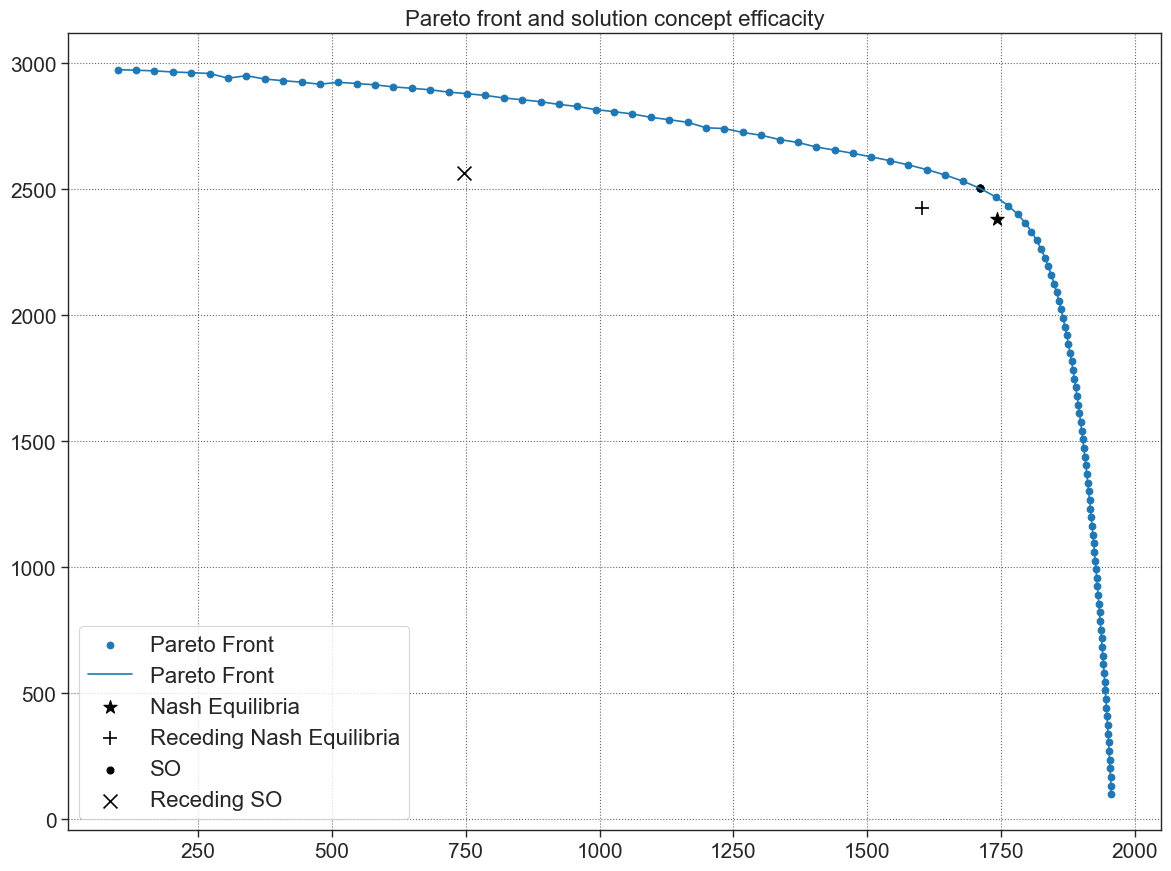

In [67]:
plt.figure( dpi=100, figsize=(12,9))
plt.scatter(arr[:,0], arr[:,1], label='Pareto Front')
plt.plot(sorted[:,0], sorted[:,1], label='Pareto Front')

plt.scatter(u_p[0], u_p[1], marker='*', c='black', s=100, label='Nash Equilibria')
plt.scatter(u_r[0], u_r[1], marker='+', c='black',s=100, label='Receding Nash Equilibria')
plt.scatter(u_p_so[0], u_p_so[1], marker='.',c='black', s=100, label='SO')
plt.scatter(u_r_so[0], u_r_so[1], marker='x',c='black', s=100, label='Receding SO')
plt.title('Pareto front and solution concept efficacity')
plt.legend()
plt.show()

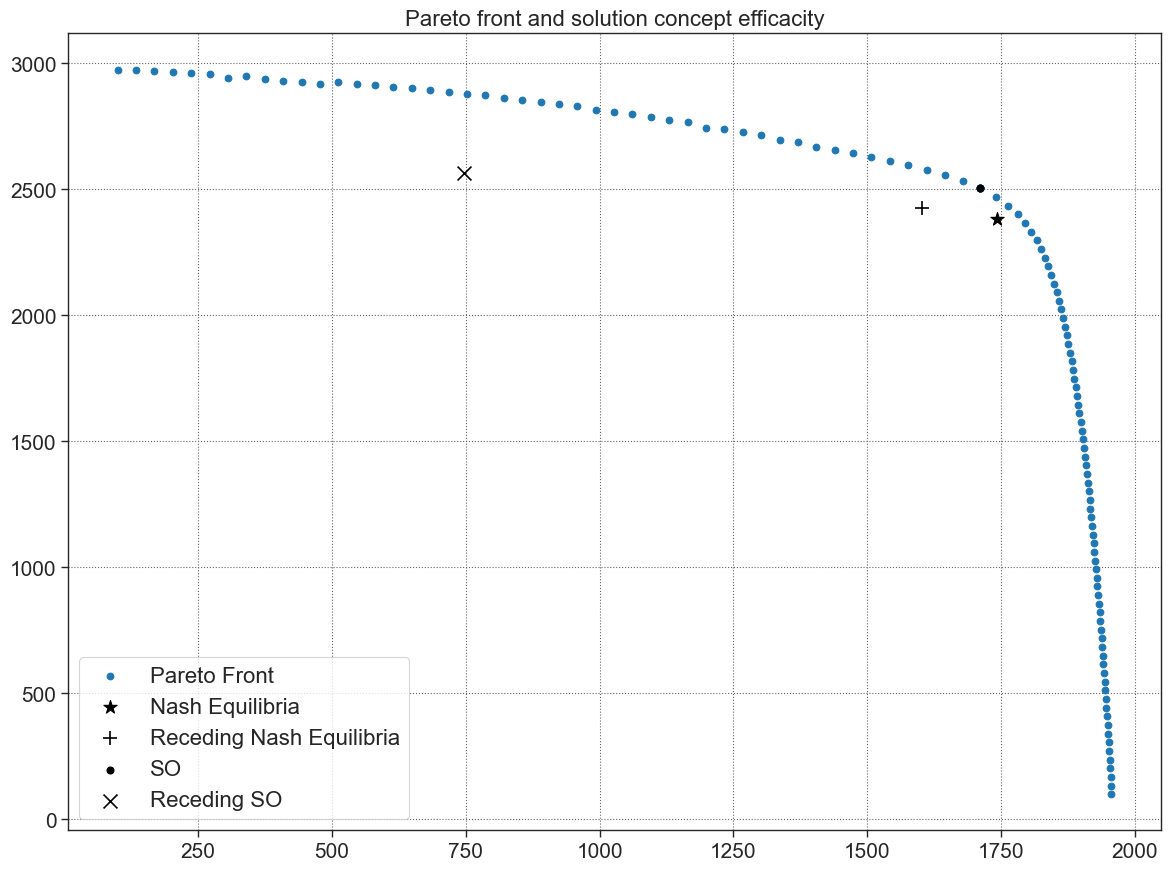

In [ ]:
plt.figure( dpi=100, figsize=(12,9))
plt.scatter(arr[:,0], arr[:,1], label='Pareto Front')

plt.scatter(u_p[0], u_p[1], marker='*', c='black', s=100, label='Nash Equilibria')
plt.scatter(u_r[0], u_r[1], marker='+', c='black',s=100, label='Receding Nash Equilibria')
plt.scatter(u_p_so[0], u_p_so[1], marker='.',c='black', s=100, label='SO')
plt.scatter(u_r_so[0], u_r_so[1], marker='x',c='black', s=100, label='Receding SO')
plt.title('Pareto front and solution concept efficacity')
plt.legend()
plt.show()

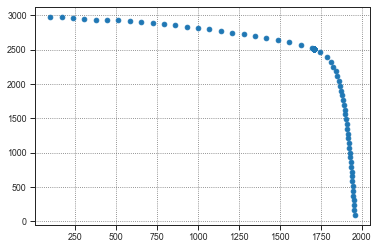

In [19]:
list_players[0].utility_sum_over_t(res[0][0], np.sum(res[0], axis =0)-res[0][0]) 

699.999999916701

In [14]:
list_players[1].utility_sum_over_t(res[0][1], np.sum(res[0], axis =0)) 

2633.4853248495824

In [5]:
game.list_players

# Action randomized

In [6]:
k = 10
num_sample = 100000

In [70]:
ACTION_SETS

array([[[ 0.  , 45.88],
        [ 0.  , 45.88],
        [ 0.  , 45.88],
        [ 0.  , 45.88],
        [ 0.  , 45.88],
        [ 0.  , 45.88],
        [ 0.  , 45.88],
        [ 0.  , 45.88],
        [ 0.  , 45.88],
        [ 0.  , 45.88],
        [ 0.  , 45.88],
        [ 0.  , 45.88],
        [ 0.  , 45.88],
        [ 0.  , 45.88],
        [ 0.  , 45.88],
        [ 0.  , 45.88],
        [ 0.  , 45.88],
        [ 0.  , 45.88],
        [ 0.  , 45.88],
        [ 0.  , 45.88],
        [ 0.  , 45.88],
        [ 0.  , 45.88],
        [ 0.  , 45.88],
        [ 0.  , 45.88],
        [ 0.  , 45.88],
        [ 0.  , 45.88],
        [ 0.  , 45.88],
        [ 0.  , 45.88],
        [ 0.  , 45.88],
        [ 0.  , 45.88],
        [ 0.  , 45.88],
        [ 0.  , 45.88],
        [ 0.  , 45.88],
        [ 0.  , 45.88]],

       [[ 0.  , 20.04],
        [ 0.  , 20.04],
        [ 0.  , 20.04],
        [ 0.  , 20.04],
        [ 0.  , 20.04],
        [ 0.  , 20.04],
        [ 0.  , 20.04],
        [ 0.  

In [71]:
lower_bounds = np.copy(ACTION_SETS[:,:T,:][..., 0])
upper_bounds = np.copy(ACTION_SETS[:,:T,:][..., 1])

In [74]:
from itertools import zip_longest
import numpy as np

def invNormal(low : np.ndarray, high : np.ndarray, loc = None, scale=1, *, size=1, block_size=1024, random_state=None):
    remain = size
    result = []
    if not loc:
        loc = (high + low) / 2
    
    mul = -0.5 * scale**-2

    while remain:
        # draw next block of uniform variates within interval
        x = np.random.uniform(low, high, size=min((remain+5)*2, block_size))
        
        # reject proportional to normal density
        x = x[np.exp(mul*(x-loc)**2) < np.random.rand(*x.shape)]
        
        # make sure we don't add too much
        if remain < len(x):
            x = x[:remain]

        result.append(x)
        remain -= len(x)

    return np.concatenate(result)

def _check_shape(argshape, size):
    """
    This is a utility function used by `_rvs()` in the class geninvgauss_gen.
    It compares the tuple argshape to the tuple size.

    Parameters
    ----------
    argshape : tuple of integers
        Shape of the arguments.
    size : tuple of integers or integer
        Size argument of rvs().

    Returns
    -------
    The function returns two tuples, scalar_shape and bc.

    scalar_shape : tuple
        Shape to which the 1-d array of random variates returned by
        _rvs_scalar() is converted when it is copied into the
        output array of _rvs().

    bc : tuple of booleans
        bc is an tuple the same length as size. bc[j] is True if the data
        associated with that index is generated in one call of _rvs_scalar().

    """
    scalar_shape = []
    bc = []
    for argdim, sizedim in zip_longest(argshape[::-1], size[::-1],
                                       fillvalue=1):
        if sizedim > argdim or (argdim == sizedim == 1):
            scalar_shape.append(sizedim)
            bc.append(True)
        else:
            bc.append(False)
    return tuple(scalar_shape[::-1]), tuple(bc[::-1])

def invNormal_rvs(a, b, loc = None, scale = 1, size=None, random_state=None):
    # if a and b are scalar, use _rvs_scalar, otherwise need to create
    # output by iterating over parameters
    if np.isscalar(a) and np.isscalar(b):
        out = invNormal(a, b, size, random_state=random_state)
    elif a.size == 1 and b.size == 1:
        out = invNormal(a.item(), b.item(), size,
                                random_state=random_state)
    else:
        # When this method is called, size will be a (possibly empty)
        # tuple of integers.  It will not be None; if `size=None` is passed
        # to `rvs()`, size will be the empty tuple ().

        a, b = np.broadcast_arrays(a, b)
        # a and b now have the same shape.

        # `shp` is the shape of the blocks of random variates that are
        # generated for each combination of parameters associated with
        # broadcasting a and b.
        # bc is a tuple the same length as size.  The values
        # in bc are bools.  If bc[j] is True, it means that
        # entire axis is filled in for a given combination of the
        # broadcast arguments.
        shp, bc = _check_shape(a.shape, size)

        # `numsamples` is the total number of variates to be generated
        # for each combination of the input arguments.
        numsamples = int(np.prod(shp))

        # `out` is the array to be returned.  It is filled in in the
        # loop below.
        out = np.empty(size)

        it = np.nditer([a, b],
                        flags=['multi_index'],
                        op_flags=[['readonly'], ['readonly']])
        while not it.finished:
            # Convert the iterator's multi_index into an index into the
            # `out` array where the call to _rvs_scalar() will be stored.
            # Where bc is True, we use a full slice; otherwise we use the
            # index value from it.multi_index.  len(it.multi_index) might
            # be less than len(bc), and in that case we want to align these
            # two sequences to the right, so the loop variable j runs from
            # -len(size) to 0.  This doesn't cause an IndexError, as
            # bc[j] will be True in those cases where it.multi_index[j]
            # would cause an IndexError.
            idx = tuple((it.multi_index[j] if not bc[j] else slice(None))
                        for j in range(-len(size), 0))
            out[idx] =  invNormal(it[0], it[1], loc=loc, scale=scale, size=numsamples,
                                        random_state = random_state).reshape(shp)
            it.iternext()

    if size == ():
        out = out.item()
    return out

In [75]:
from itertools import zip_longest
import numpy as np
from scipy.stats import norm

def truncNormal(low : np.ndarray, high : np.ndarray, loc = 0, scale=1, *, size=1, block_size=1024, random_state=None):
    remain = size
    result = []

    while remain:
        # draw next block of uniform variates within interval
        x = np.random.normal(loc=loc, scale=scale, size=block_size)
        
        # reject proportional to normal density
        x = x[low < x]
        x = x[x <high]
        # make sure we don't add too much
        if remain < len(x):
            x = x[:remain]

        result.append(x)
        remain -= len(x)

    return np.concatenate(result)

def _check_shape(argshape, size):
    """
    This is a utility function used by `_rvs()` in the class geninvgauss_gen.
    It compares the tuple argshape to the tuple size.

    Parameters
    ----------
    argshape : tuple of integers
        Shape of the arguments.
    size : tuple of integers or integer
        Size argument of rvs().

    Returns
    -------
    The function returns two tuples, scalar_shape and bc.

    scalar_shape : tuple
        Shape to which the 1-d array of random variates returned by
        _rvs_scalar() is converted when it is copied into the
        output array of _rvs().

    bc : tuple of booleans
        bc is an tuple the same length as size. bc[j] is True if the data
        associated with that index is generated in one call of _rvs_scalar().

    """
    scalar_shape = []
    bc = []
    for argdim, sizedim in zip_longest(argshape[::-1], size[::-1],
                                       fillvalue=1):
        if sizedim > argdim or (argdim == sizedim == 1):
            scalar_shape.append(sizedim)
            bc.append(True)
        else:
            bc.append(False)
    return tuple(scalar_shape[::-1]), tuple(bc[::-1])

def truncNormal_rvs(a, b, loc = None, scale = 1, size=None, random_state=None):
    # if a and b are scalar, use _rvs_scalar, otherwise need to create
    # output by iterating over parameters
    if np.isscalar(a) and np.isscalar(b):
        out = truncNormal(a, b, size, random_state=random_state)
    elif a.size == 1 and b.size == 1:
        out = truncNormal(a.item(), b.item(), size,
                                random_state=random_state)
    else:
        # When this method is called, size will be a (possibly empty)
        # tuple of integers.  It will not be None; if `size=None` is passed
        # to `rvs()`, size will be the empty tuple ().

        a, b = np.broadcast_arrays(a, b)
        # a and b now have the same shape.

        # `shp` is the shape of the blocks of random variates that are
        # generated for each combination of parameters associated with
        # broadcasting a and b.
        # bc is a tuple the same length as size.  The values
        # in bc are bools.  If bc[j] is True, it means that
        # entire axis is filled in for a given combination of the
        # broadcast arguments.
        shp, bc = _check_shape(a.shape, size)

        # `numsamples` is the total number of variates to be generated
        # for each combination of the input arguments.
        numsamples = int(np.prod(shp))

        # `out` is the array to be returned.  It is filled in in the
        # loop below.
        out = np.empty(size)

        it = np.nditer([a, b],
                        flags=['multi_index'],
                        op_flags=[['readonly'], ['readonly']])
        while not it.finished:
            # Convert the iterator's multi_index into an index into the
            # `out` array where the call to _rvs_scalar() will be stored.
            # Where bc is True, we use a full slice; otherwise we use the
            # index value from it.multi_index.  len(it.multi_index) might
            # be less than len(bc), and in that case we want to align these
            # two sequences to the right, so the loop variable j runs from
            # -len(size) to 0.  This doesn't cause an IndexError, as
            # bc[j] will be True in those cases where it.multi_index[j]
            # would cause an IndexError.
            idx = tuple((it.multi_index[j] if not bc[j] else slice(None))
                        for j in range(-len(size), 0))
            out[idx] =  truncNormal(it[0], it[1], loc=loc, scale=scale, size=numsamples,
                                        random_state = random_state).reshape(shp)
            it.iternext()

    if size == ():
        out = out.item()
    return out

In [68]:
from scipy.stats import norm
from ipywidgets import interact

def f(a,b,loc, scale):
    rv = norm(loc= loc, scale=scale)
    remain = 10000
    epoch = 1024
    vector = []
    while remain>0:
        
        vect = norm.rvs( loc= loc, scale=scale, size=epoch)
        vect = vect[ a < vect]
        vect = vect[vect < b]
        if len(vect) >remain:
            vect = vect[:remain]
        vector.append(vect)
        remain -= min(len(vect), epoch)

    vector = np.concatenate(vector)

    x = np.linspace(a,b)
    plt.plot(x, rv.pdf(x))
    plt.hist(norm.rvs( loc=loc, scale=scale, size=10000), bins=50, density=True, alpha= 0.5)
    plt.hist(vector, bins=50, density=True, alpha=0.5)
interact(f, a=(-12,10),b= (-10,10),loc=(-10,10),scale=(1,3))

interactive(children=(IntSlider(value=-1, description='a', max=10, min=-12), IntSlider(value=0, description='b…

<function __main__.f(a, b, loc, scale)>

(50,)
(50,)


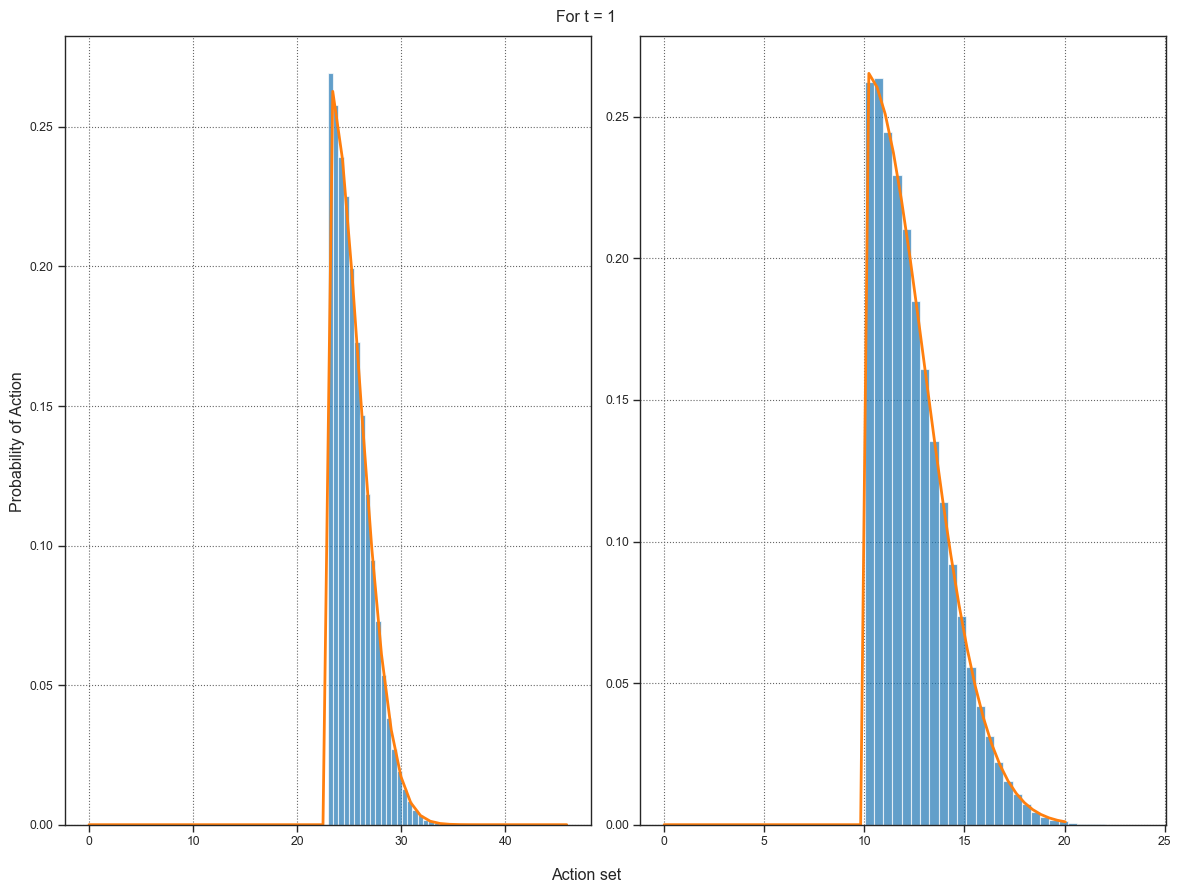

In [47]:
from scipy.stats import truncnorm


# Generate random vectors within the specified bounds

n_row = 1
n_col = 2
size = 100_001


a = lower_bounds
b = upper_bounds
lam = 1/2
loc = lam * np.array([a[0], b[1]]) + (1-lam) * np.array([b[0], a[1]]) 
scale = 3
random_vector = truncnorm.rvs(a=a, b=b, loc= loc, scale=scale, size=(size, N, T))

plt.rcParams["figure.autolayout"] = True

fig, axes = plt.subplots(n_row, n_col, dpi = 100, figsize=(12,9))
t = 0
k = 0
for row in range(n_row):
    for col in range(n_col):
        axes[col].hist(random_vector[:,k,t], bins=30,  alpha=0.7, density=True)
        x = np.linspace(ACTION_SETS[k,t,0],ACTION_SETS[k,t,1])
        rv = truncnorm(b=b[k,t], a=a[k,t], loc = loc[k,t], scale=scale)
        print(x.shape)
        axes[col].plot(x, rv.pdf(x), lw=2)
        k += 1
fig.supylabel('Probability of Action')
fig.supxlabel('Action set')

fig.suptitle('For t = {}'.format(t +1))

plt.show()

In [342]:
random_vector.shape

(100000, 2, 17)

In [11]:
ACTION_SETS[:,:T,:].shape

(2, 17, 2)

In [75]:
(size, ACTION_SETS[:,:T,:].shape[0], ACTION_SETS[:,:T,:].shape[1])

(100000, 2, 17)

In [77]:
n_row = 1
n_col = 2
size = 1_0000

def f (lam):
    loc = lam * np.array([lower_bounds[0,0], upper_bounds[1,0]]) + (1 - lam) * np.array([upper_bounds[0,0], lower_bounds[1,0]])
    random_vector = truncNormal_rvs(lower_bounds[0], upper_bounds[0], loc=loc[0], scale= 2, size=(size, ACTION_SETS[:,:T,:].shape[1]))
    random_vector2 = truncNormal_rvs(lower_bounds[1], upper_bounds[1], loc=loc[1], scale= 2, size=(size,  ACTION_SETS[:,:T,:].shape[1]))

    random_vector = np.stack((random_vector,random_vector2), axis=1)

    plt.rcParams["figure.autolayout"] = True

    fig, axes = plt.subplots(n_row, n_col, dpi = 100, figsize=(12,9))
    t = 0
    k = 0
    for row in range(n_row):
        for col in range(n_col):
            axes[col].hist(random_vector[:,k,t], bins=100,  alpha=0.7, density=True)
            k += 1
    fig.supylabel('Probability of Action')
    fig.supxlabel('Action set')

    fig.suptitle('For t = {}'.format(t +1))

    plt.show()

interact(f, lam=(0,1,0.01))

interactive(children=(FloatSlider(value=0.0, description='lam', max=1.0, step=0.01), Output()), _dom_classes=(…

<function __main__.f(lam)>

In [12]:
scale =2

In [13]:
def genererate_proportional(lam):
    loc = lam * np.array([lower_bounds[0,0], lower_bounds[1,0]]) + (1 - lam) * np.array([upper_bounds[0,0], upper_bounds[1,0]])
    random_vector = truncNormal_rvs(lower_bounds[0], upper_bounds[0], loc=loc[0], scale= scale, size=(size, ACTION_SETS[:,:T,:].shape[1]))
    random_vector2 = truncNormal_rvs(lower_bounds[1], upper_bounds[1], loc=loc[1], scale= scale, size=(size,  ACTION_SETS[:,:T,:].shape[1]))

    random_vector = np.stack((random_vector,random_vector2), axis=1)
    return random_vector

In [14]:
def genererate_symetry(lam):
    loc = lam * np.array([lower_bounds[0,0], upper_bounds[1,0]]) + (1 - lam) * np.array([upper_bounds[0,0], lower_bounds[1,0]])
    random_vector = truncNormal_rvs(lower_bounds[0], upper_bounds[0], loc=loc[0], scale= scale, size=(size, ACTION_SETS[:,:T,:].shape[1]))
    random_vector2 = truncNormal_rvs(lower_bounds[1], upper_bounds[1], loc=loc[1], scale= scale, size=(size,  ACTION_SETS[:,:T,:].shape[1]))

    random_vector = np.stack((random_vector,random_vector2), axis=1)
    return random_vector

In [24]:
scale = 2
size = 1_000
x= np.concatenate([np.concatenate([genererate_proportional(lam), genererate_symetry(lam)]) for lam in np.linspace(.6,0.7,30, endpoint=True)])


In [32]:
x= np.concatenate([genererate_symetry(lam) for lam in np.linspace(.1,.9,100, endpoint=True)])


In [25]:
x= np.concatenate([genererate_proportional(lam) for lam in np.linspace(.5,.9,100, endpoint=True)])


In [26]:
x.shape

(100000, 2, 17)

In [88]:
def test(lam):
    def f(alpha, x):
        return alpha * x
    
    fig, axes = plt.subplots(2)
    alpha = lam * np.array([2,-2]) + (1-lam ) * np.array([-2,5])
    x = np.linspace(-1,1)
    axes[0].plot(x, f(alpha[0] ,x))
    axes[1].plot(x, f(alpha[1], x))
    plt.show()

interact(test, lam=(0,1,0.1))

interactive(children=(FloatSlider(value=0.0, description='lam', max=1.0), Output()), _dom_classes=('widget-int…

<function __main__.test(lam)>

IndexError: index 2 is out of bounds for axis 1 with size 2

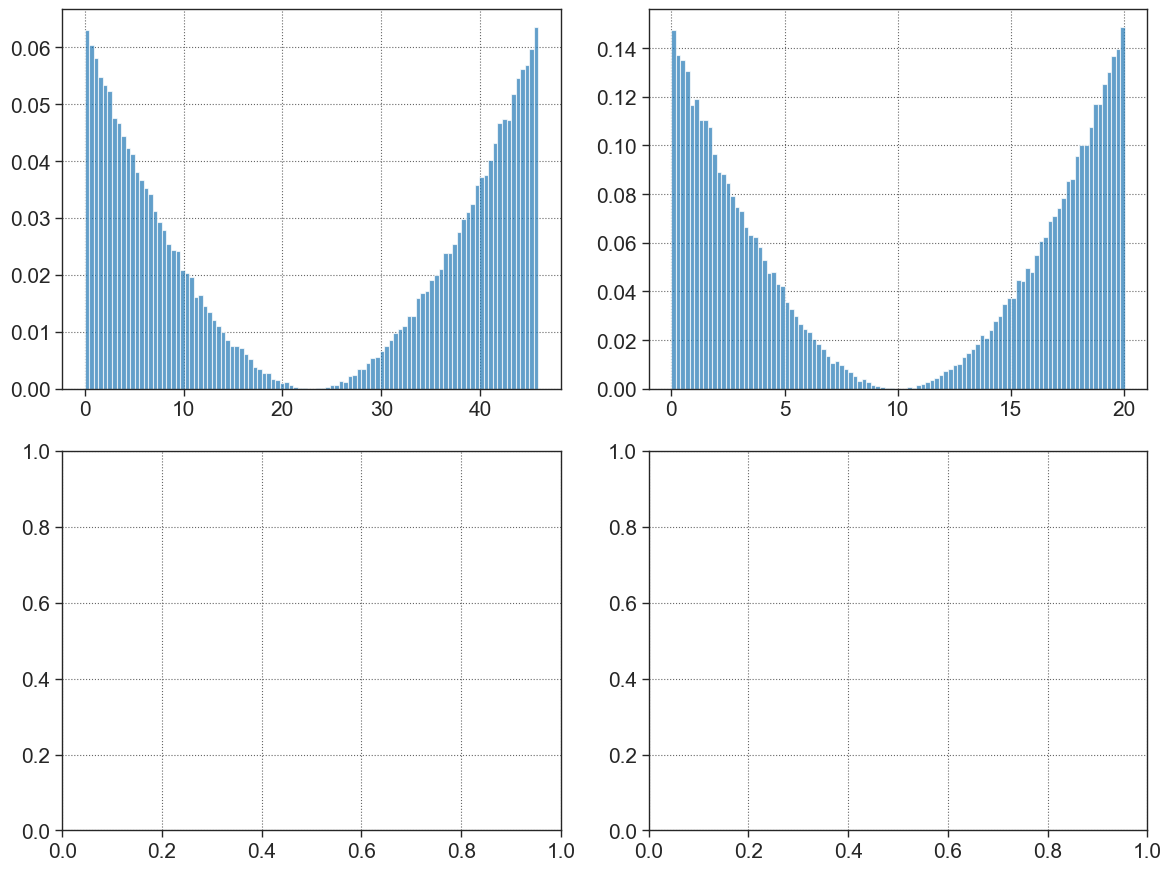

In [338]:
n_row = 2
n_col = 2
size = 100_000
random_vector = invNormal_rvs(lower_bounds, upper_bounds, scale= 60, size=(size, ACTION_SETS[:,:T,:].shape[0], ACTION_SETS[:,:T,:].shape[1]))

plt.rcParams["figure.autolayout"] = True

fig, axes = plt.subplots(n_row, n_col, dpi = 100, figsize=(12,9))
t = 0
k = 0
for row in range(n_row):
    for col in range(n_col):
        axes[row, col].hist(random_vector[:,k,t], bins=100,  alpha=0.7, density=True)
        k += 1
fig.supylabel('Probability of Action')
fig.supxlabel('Action set')

fig.suptitle('For t = {}'.format(t +1))

plt.show()


IndexError: index 2 is out of bounds for axis 1 with size 2

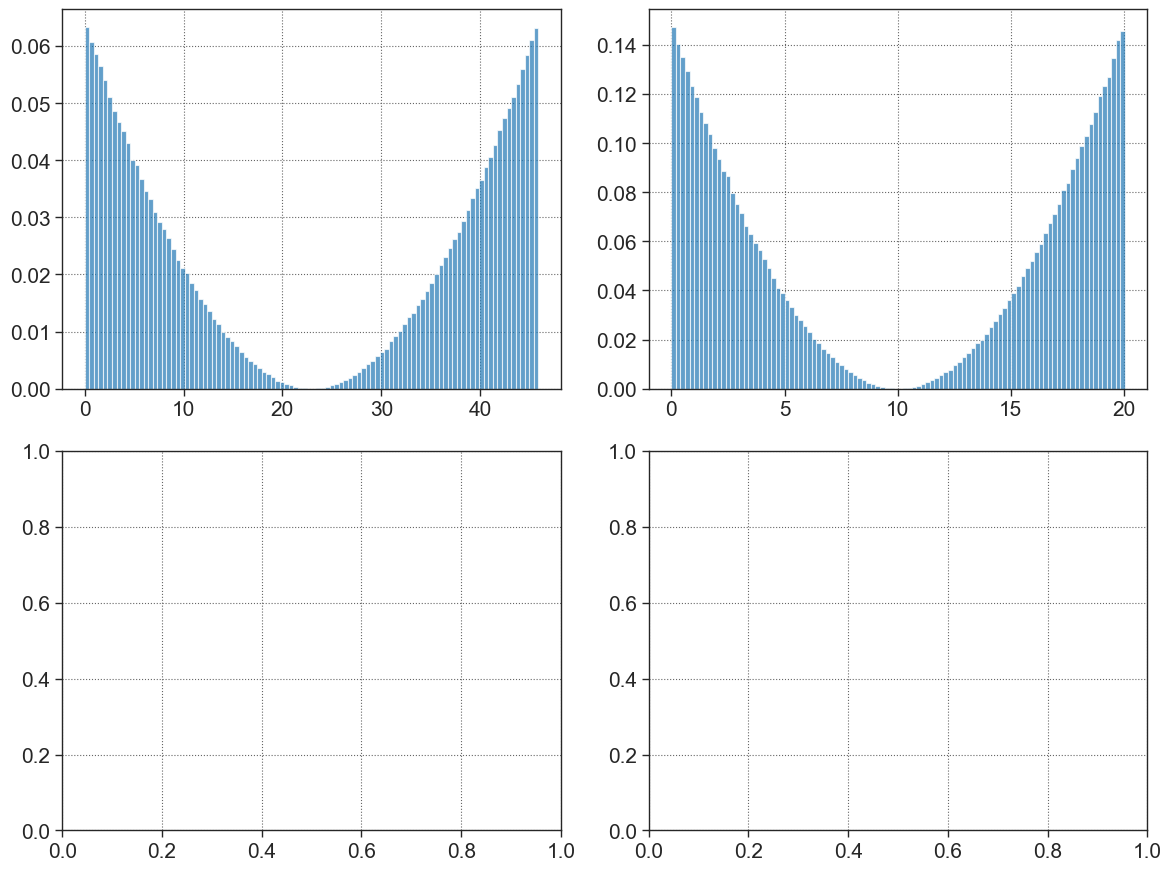

In [ ]:
n_row = 2
n_col = 2
size = 100_000
random_vector = invNormal_rvs(lower_bounds, upper_bounds, scale= 60, size=(size, ACTION_SETS[:,:T,:].shape[0], ACTION_SETS[:,:T,:].shape[1]))

plt.rcParams["figure.autolayout"] = True

fig, axes = plt.subplots(n_row, n_col, dpi = 100, figsize=(12,9))
t = 0
k = 0
for row in range(n_row):
    for col in range(n_col):
        axes[row, col].hist(random_vector[:,k,t], bins=100,  alpha=0.7, density=True)
        k += 1
fig.supylabel('Probability of Action')
fig.supxlabel('Action set')

fig.suptitle('For t = {}'.format(t +1))

plt.show()


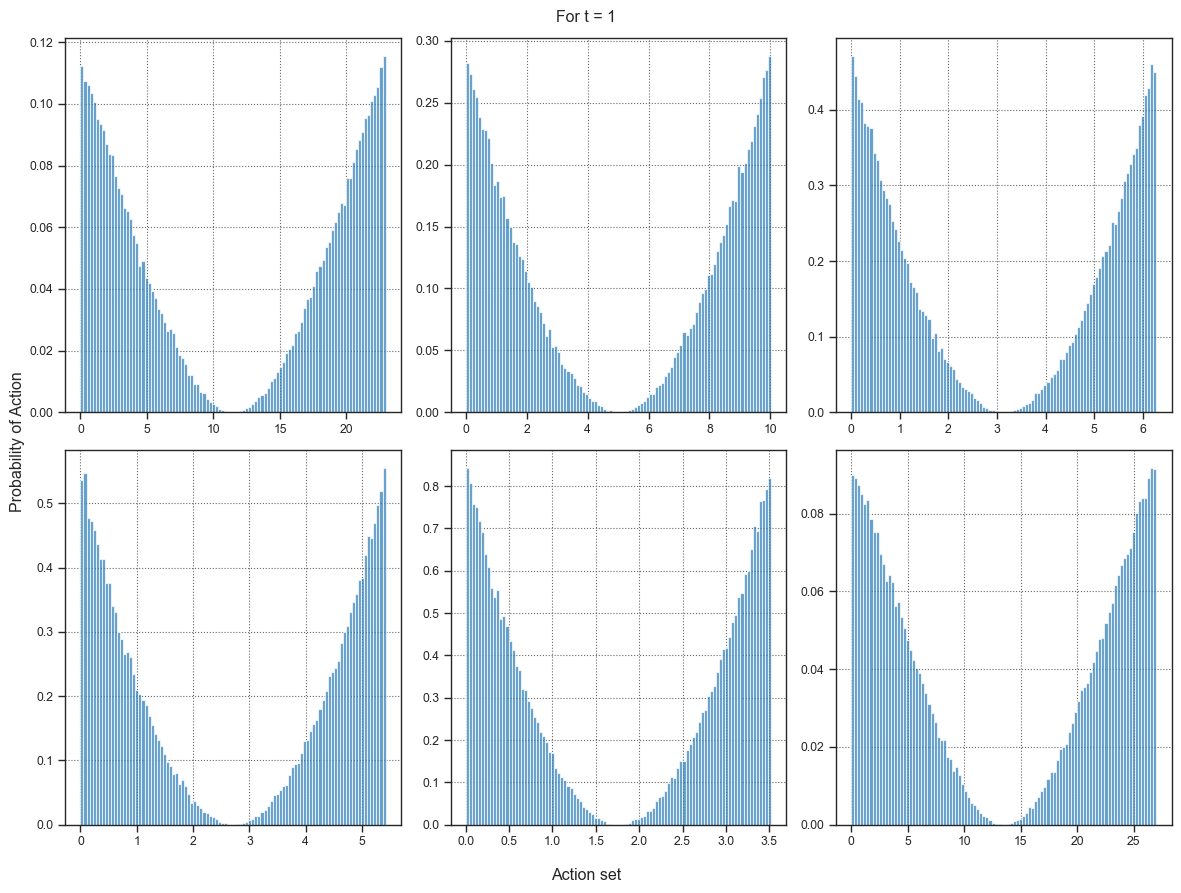

In [ ]:
n_row = 2
n_col = 3
size = 100000
random_vector = invNormal_rvs(lower_bounds, upper_bounds, scale= 10, size=(size, ACTION_SETS[:,:T,:].shape[0], ACTION_SETS[:,:T,:].shape[1]))

plt.rcParams["figure.autolayout"] = True

fig, axes = plt.subplots(n_row, n_col, dpi = 100, figsize=(12,9))
t = 0
k = 0
for row in range(n_row):
    for col in range(n_col):
        axes[row, col].hist(random_vector[:,k,t], bins=100,  alpha=0.7, density=True)
        k += 1
fig.supylabel('Probability of Action')
fig.supxlabel('Action set')

fig.suptitle('For t = {}'.format(t +1))

plt.show()


In [21]:
game.game_with_strategies_profile(random_vector[0], 0*np.sum(random_vector, axis = 1)[10])

NameError: name 'random_vector' is not defined

In [17]:
def process(list_strategy_profile, game : Game) : 
    data_utilities = []
    data_temp = []
    list_sum_strategy = np.sum(list_strategy_profile, axis=1)
    list_ = list(zip(list_strategy_profile,list_sum_strategy))
    for strategy, sum_ in tqdm(list_, total = len(list_), desc ='Processing'):
        u,temp = game.game_with_strategies_profile(strategy,sum_)
        data_utilities.append(u)
        data_temp.append(temp)
    return np.array(data_utilities), np.array(data_temp)

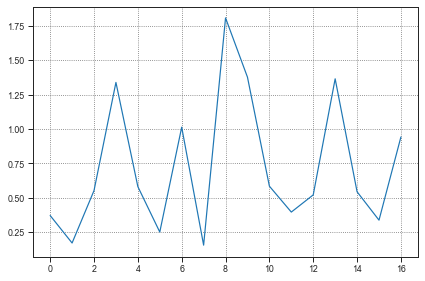

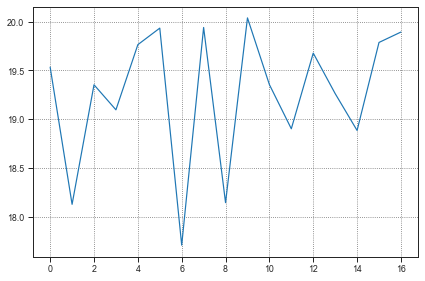

In [110]:
for k in range(2):
    plt.plot(random_vector[0][k])
    plt.show()

In [102]:
list_players = create_players(alpha=2, list_action_sets=ACTION_SETS, list_of_names=NAMES, list_benefit_functions=list_list_benefit_functions[0], damage_function=damage_polynome(list_damage_coef[0]), discount=1)

game = Game(list_players, horizon=horizon)

In [23]:
game.reset()
a_rece, sum_a_rece, u_rece, sum_u_rece, temp_rece = game.receding_BRD_by_piece_return(17)
game.reset()
a_plan, sum_a_plan, u_plan, sum_u_plan, temp_plan = game.planning_BRD_by_piece_return(17)

game.reset()
a_plan_so, sum_a_plan_so, u_plan_so, sum_u_plan_so, temp_plan_so = game.planning_SO_by_piece_return(17)
game.reset()
a_rece_so, sum_a_rece_so, u_rece_so, sum_u_rece_so, temp_rece_so = game.receding_SO_by_piece_return(17)

u_p = np.sum(u_plan, axis=1)
u_r = np.sum(u_rece, axis=1)
u_p_so = np.sum(u_plan_so, axis =1)
u_r_so = np.sum(u_rece_so, axis =1)

Planning SO, t_piece = 17:   0%|          | 0/1 [00:00<?, ?it/s]

SO SLSQP 0.3368229866027832


Planning SO, t_piece = 17: 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]


SO L-BFGS-B: 0.2356889247894287


Receding SO, t_piece = 17:   0%|          | 0/17 [00:00<?, ?it/s]

SO SLSQP 0.46225666999816895


Receding SO, t_piece = 17:   6%|▌         | 1/17 [00:00<00:13,  1.17it/s]

SO L-BFGS-B: 0.39366745948791504
SO SLSQP 0.5244002342224121


Receding SO, t_piece = 17:  12%|█▏        | 2/17 [00:01<00:12,  1.16it/s]

SO L-BFGS-B: 0.33919453620910645
SO SLSQP 0.4223809242248535


Receding SO, t_piece = 17:  18%|█▊        | 3/17 [00:02<00:11,  1.25it/s]

SO L-BFGS-B: 0.29852986335754395
SO SLSQP 0.31713414192199707


Receding SO, t_piece = 17:  24%|██▎       | 4/17 [00:03<00:09,  1.34it/s]

SO L-BFGS-B: 0.3414034843444824
SO SLSQP 0.4439976215362549


Receding SO, t_piece = 17:  29%|██▉       | 5/17 [00:03<00:09,  1.28it/s]

SO L-BFGS-B: 0.4025871753692627
SO SLSQP 0.41562914848327637


Receding SO, t_piece = 17:  35%|███▌      | 6/17 [00:04<00:08,  1.29it/s]

SO L-BFGS-B: 0.3462984561920166
SO SLSQP 0.614532470703125


Receding SO, t_piece = 17:  41%|████      | 7/17 [00:05<00:08,  1.16it/s]

SO L-BFGS-B: 0.41705942153930664
SO SLSQP 0.353579044342041


Receding SO, t_piece = 17:  47%|████▋     | 8/17 [00:06<00:07,  1.17it/s]

SO L-BFGS-B: 0.4963054656982422
SO SLSQP 0.49662160873413086


Receding SO, t_piece = 17:  53%|█████▎    | 9/17 [00:07<00:06,  1.16it/s]

SO L-BFGS-B: 0.3625955581665039
SO SLSQP 0.4997217655181885


Receding SO, t_piece = 17:  59%|█████▉    | 10/17 [00:08<00:05,  1.17it/s]

SO L-BFGS-B: 0.3324277400970459
SO SLSQP 0.6025433540344238


Receding SO, t_piece = 17:  65%|██████▍   | 11/17 [00:09<00:05,  1.02it/s]

SO L-BFGS-B: 0.6748847961425781
SO SLSQP 0.7855381965637207


Receding SO, t_piece = 17:  71%|███████   | 12/17 [00:11<00:05,  1.13s/it]

SO L-BFGS-B: 0.6763255596160889
SO SLSQP 0.7260291576385498


Receding SO, t_piece = 17:  76%|███████▋  | 13/17 [00:12<00:05,  1.29s/it]

SO L-BFGS-B: 0.9419090747833252
SO SLSQP 0.6436440944671631


Receding SO, t_piece = 17:  82%|████████▏ | 14/17 [00:13<00:03,  1.28s/it]

SO L-BFGS-B: 0.6164076328277588
SO SLSQP 0.5805160999298096


Receding SO, t_piece = 17:  88%|████████▊ | 15/17 [00:15<00:02,  1.25s/it]

SO L-BFGS-B: 0.5821213722229004
SO SLSQP 0.5223565101623535


Receding SO, t_piece = 17:  94%|█████████▍| 16/17 [00:16<00:01,  1.24s/it]

SO L-BFGS-B: 0.6960384845733643
SO SLSQP 0.68094801902771


Receding SO, t_piece = 17: 100%|██████████| 17/17 [00:17<00:00,  1.04s/it]

SO L-BFGS-B: 0.6959376335144043


In [114]:
def generate_perturbation(action, lower_bounds=lower_bounds, upper_bounds=upper_bounds, size=5000, scale=.05):
    shape = action.shape
    perturbation = stats.norm.rvs(loc = 0, scale=scale, size=(size,*shape))
    # perturbation = truncNormal_rvs(action - lower_bounds, upper_bounds - action, loc=0, scale= scale, size=(size, *shape))
    arr = action + perturbation
    res = np.where(arr < upper_bounds, arr, upper_bounds)
    res = np.where(arr > lower_bounds, arr, lower_bounds)
    return res

In [115]:
x = np.concatenate([np.concatenate([generate_perturbation(a_plan_so, scale=scale), generate_perturbation(a_plan, scale=scale), generate_perturbation(a_rece, scale=scale), generate_perturbation(a_rece_so, scale=scale)]) for scale in [0.05, 0.15, 0.5, 1, 1.5 ,2]])

In [33]:
ACTION_SETS[:,:2,:]

array([[[ 0.  , 45.88],
        [ 0.  , 45.88]],

       [[ 0.  , 20.04],
        [ 0.  , 20.04]]])

In [206]:
a_planning_piece/ACTION_SETS[:,:T,1]

array([[0.74559004, 0.74312895, 0.74097388, 0.73914544, 0.73754812,
        0.73597463, 0.73458532, 0.73318148, 0.73176814, 0.7301613 ,
        0.72854104, 0.72692671, 0.72522493, 0.72347648, 0.72169211,
        0.72008122, 0.71825981],
       [0.72174314, 0.71876056, 0.71645863, 0.71446516, 0.7125468 ,
        0.71100224, 0.70920845, 0.70752297, 0.70597078, 0.70419931,
        0.7022755 , 0.70046379, 0.69851949, 0.69667493, 0.69461169,
        0.69273956, 0.6906939 ]])

In [34]:
a_planning_piece_so

array([[18.3371081 , 18.46034428, 18.61806296, 18.80820059, 19.03834535,
        19.30298867, 19.60550061, 19.94667788, 20.33229338, 20.77151734,
        21.28099146, 21.88951371, 22.63339643, 23.57795828, 24.85604743,
        26.83298234, 30.46389671],
       [ 7.97821944,  8.01009462,  8.05988525,  8.14170094,  8.24513955,
         8.34829185,  8.44762115,  8.56716761,  8.71997866,  8.90789209,
         9.12136095,  9.3701495 ,  9.68507734, 10.10602998, 10.69343405,
        11.61085836, 13.33596603]])

In [95]:
x = np.concatenate([generate_perturbation(a_planning_piece_so, lower_bounds, upper_bounds, scale=scale) for scale in [0.05, 0.15, 0.5, 1, 1.5 ,2]])

In [108]:
x.shape

(120000, 2, 17)

In [91]:
np.sum(upper_bounds - x[0]> 0)

34

In [ ]:
for l in x :
    if (upper_bounds < l).any() :
        print( upper_bounds - l ) 

[[23.83703507 22.50536609 20.68932424 20.81671219 23.04073925 18.7341018
  20.55423865 21.93497542 23.06790229 19.03609724 22.83127545 20.27672455
  17.29401887 14.93042626 17.06774018 14.81674302 10.27005628]
 [10.09877356 10.89339329 12.63841213 10.18581626 12.15163283  8.96390829
   7.85726143 11.8363695   7.03845888 13.43417287 10.14077409  6.66875792
   9.42519921  8.15060857 11.75102943  9.65049307 -1.62565831]]
[[22.12285667 22.6083791  21.70283262 22.72302879 23.0943168  23.03677883
  21.56601206 20.81031165 20.53043478 22.92605977 22.74227711 22.42500647
  19.18050141 16.78624743 17.67569979 12.43043019 10.14589061]
 [13.22260083 14.06232865 10.3369397  11.82577936 10.90553129 12.37566204
   8.97341669 13.78640198  7.39657234 11.38463877  8.99713513 11.29974425
   8.73867998  6.33918833 11.13856295  5.14357488 -2.1386742 ]]
[[23.23572503 26.48551061 23.56981134 25.64945783 22.06991045 22.70906619
  21.05980129 23.17073762 18.60494781 21.01703332 20.62513584 21.37630983
  20.44

In [76]:
import numpy as np

def get_lower_components(array, up_bound):
    lower_array = np.where(array < up_bound, array, up_bound)
    return lower_array

# Example usage
size = 5


# Generate a random array
array = np.random.random((size, N, T))
print("Array:")
print(array)

# Generate a random upper bound vector
up_bound = np.ones_like(array)*0.1
print("Upper Bound:")
print(up_bound)

# Get the lower components
lower_components = get_lower_components(array, up_bound)
print("Lower Components:")
print(lower_components)


Array:
[[[8.84467679e-01 8.30028204e-01 3.29951515e-01 2.27654132e-01]
  [8.30746256e-01 3.09096712e-01 3.60203624e-02 7.63343432e-01]
  [1.83381812e-01 1.42827820e-01 6.57401696e-02 4.29651706e-01]]

 [[3.39046980e-01 8.23201397e-01 2.14264448e-01 1.86203783e-01]
  [5.42659461e-02 5.30182485e-01 5.30961444e-01 6.08371102e-01]
  [1.13633836e-01 2.45622624e-03 3.16344922e-01 1.37012539e-02]]

 [[8.15795647e-01 1.65464012e-01 9.53490453e-01 3.04503081e-01]
  [3.97739428e-01 7.71986465e-01 7.13276145e-01 4.71735941e-01]
  [8.30898921e-01 6.72140194e-01 6.96498280e-01 1.65908212e-01]]

 [[8.00418759e-01 9.13989080e-01 9.83289013e-01 2.50693874e-01]
  [5.00986094e-01 7.80268931e-01 3.50828224e-01 8.85030134e-01]
  [5.22717467e-01 2.54473701e-02 7.72986977e-01 5.33918484e-01]]

 [[9.65146850e-04 3.82994511e-01 3.06081359e-01 8.52081454e-01]
  [7.98609157e-01 1.55710036e-01 4.78180514e-01 1.93868009e-02]
  [5.70495137e-01 5.72169473e-01 6.74570212e-01 1.22336666e-01]]]
Upper Bound:
[[[0.1 0.1

In [72]:
x = x[ x < upper_bounds]

In [68]:
x.shape

(1019997,)

In [48]:
lower_bounds

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]])

In [49]:
a_planning_piece_so - lower_bounds

array([[18.3371081 , 18.46034428, 18.61806296, 18.80820059, 19.03834535,
        19.30298867, 19.60550061, 19.94667788, 20.33229338, 20.77151734,
        21.28099146, 21.88951371, 22.63339643, 23.57795828, 24.85604743,
        26.83298234, 30.46389671],
       [ 7.97821944,  8.01009462,  8.05988525,  8.14170094,  8.24513955,
         8.34829185,  8.44762115,  8.56716761,  8.71997866,  8.90789209,
         9.12136095,  9.3701495 ,  9.68507734, 10.10602998, 10.69343405,
        11.61085836, 13.33596603]])

In [50]:
upper_bounds - a_planning_piece_so 

array([[27.5428919 , 27.41965572, 27.26193704, 27.07179941, 26.84165465,
        26.57701133, 26.27449939, 25.93332212, 25.54770662, 25.10848266,
        24.59900854, 23.99048629, 23.24660357, 22.30204172, 21.02395257,
        19.04701766, 15.41610329],
       [12.06178056, 12.02990538, 11.98011475, 11.89829906, 11.79486045,
        11.69170815, 11.59237885, 11.47283239, 11.32002134, 11.13210791,
        10.91863905, 10.6698505 , 10.35492266,  9.93397002,  9.34656595,
         8.42914164,  6.70403397]])

In [33]:
game.reset()
data_u, data_t = process(x, game)


Processing: 100%|██████████| 100000/100000 [01:07<00:00, 1473.44it/s]


In [185]:
x.shape

(600000, 2, 4)

In [186]:
T

4

In [182]:
data_t[:,16]

IndexError: index 16 is out of bounds for axis 1 with size 4

In [34]:
u_p = np.sum(u_plan, axis=1)
u_r = np.sum(u_rece, axis=1)
u_p_so = np.sum(u_plan_so, axis =1)
u_r_so = np.sum(u_rece_so, axis =1)

In [35]:
sns.set_style('ticks',  {"axes.grid" : "True", "grid.color": ".4", "grid.linestyle": ":"})
sns.set_context('paper')
plt.rcParams.update({'mathtext.default':  'regular' })
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.labelsize']  =15
plt.rcParams['xtick.labelsize']  =15
plt.rcParams['legend.fontsize']  = 16
plt.rcParams['axes.labelsize' ] = 16
plt.rcParams['font.size'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams["figure.autolayout"] = True


In [35]:
x,temp_plan[0]

(array([[[40.40292258, 44.04853493, 38.98043481, ..., 41.40190703,
          39.88319771, 39.41814017],
         [ 3.14401263,  5.20773041,  5.79615412, ...,  2.31200923,
           1.76910008,  4.13628502]],
 
        [[39.68298809, 40.49834119, 40.21844927, ..., 38.39580213,
          38.61840438, 42.396822  ],
         [ 1.81829284,  1.73229609,  1.26029771, ...,  3.43896672,
           5.71351211,  3.1144467 ]],
 
        [[44.058201  , 38.64116946, 43.44762337, ..., 35.96751019,
          38.75074673, 39.7187938 ],
         [ 0.17477155,  3.02367989,  0.60960261, ...,  2.80497738,
           1.17880935,  0.84135251]],
 
        ...,
 
        [[ 6.19151299,  5.36170405,  3.56126713, ...,  3.34210203,
           4.50224029,  4.71797909],
         [15.41014973, 17.15982943, 19.0418074 , ..., 17.2506753 ,
          14.62770302, 16.71766808]],
 
        [[ 2.36131691,  6.57124107,  5.71521463, ...,  4.29895192,
           3.41210335,  5.08686629],
         [15.77759777, 16.60624791, 1

C:\Users\Anthony Couthures\AppData\Local\Temp\ipykernel_18208\2719120300.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(p)


0.5


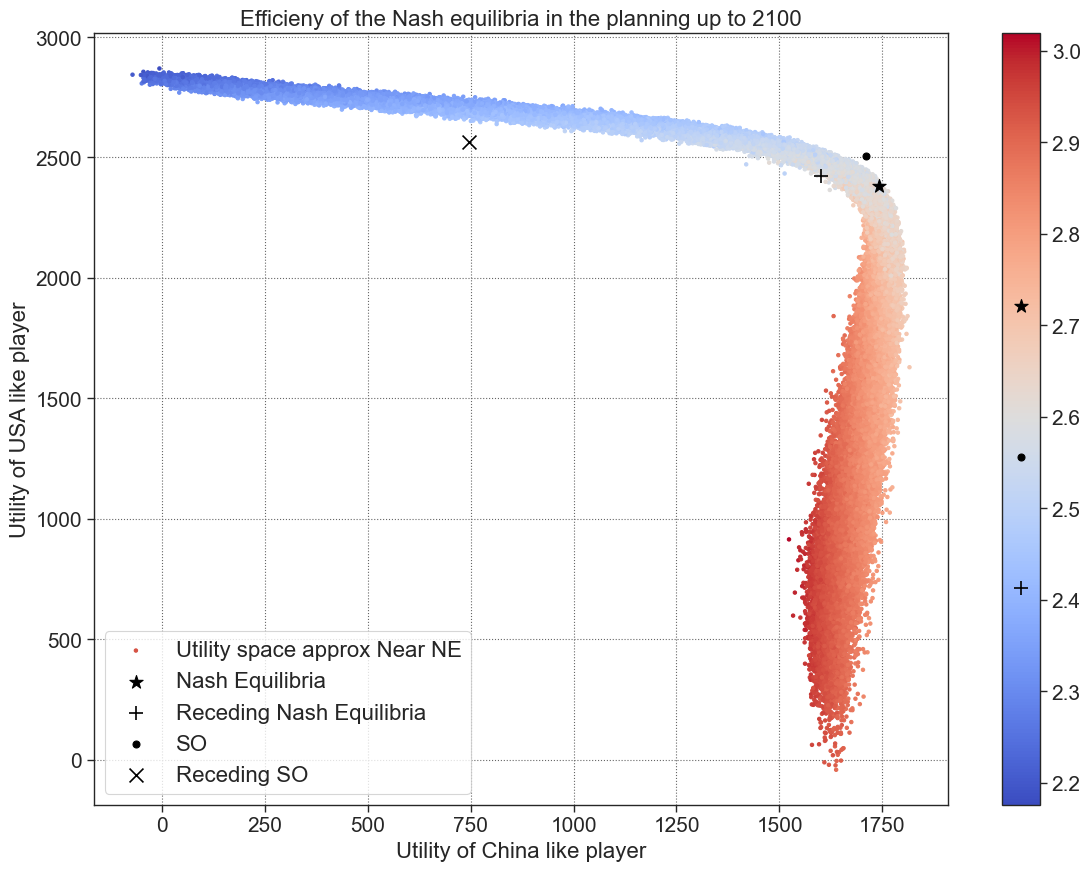

In [36]:
fig = plt.figure(dpi = 100, figsize=(12,9))
ax = fig.gca()
p = ax.scatter(data_u[:,0], data_u[:,1], c=data_t[:,16],cmap='coolwarm', marker='.', label='Utility space approx Near NE')
cbar = fig.colorbar(p)

ax.scatter(u_p[0], u_p[1], marker='*', c='black', s=100, label='Nash Equilibria')
ax.scatter(u_r[0], u_r[1], marker='+', c='black',s=100, label='Receding Nash Equilibria')
ax.scatter(u_p_so[0], u_p_so[1], marker='.',c='black', s=100, label='SO')
ax.scatter(u_r_so[0], u_r_so[1], marker='x',c='black', s=100, label='Receding SO')
x_s = cbar.ax.set_xlim()
x_s = sum(x_s)/2
print(x_s)
ax.legend()

cbar.ax.scatter(x_s,temp_plan[16], marker='*', c='black', s=100, label='Nash Equilibria')
cbar.ax.scatter(x_s,temp_rece[16], marker='+', c='black',s=100, label='Receding Nash Equilibria')
cbar.ax.scatter(x_s,temp_plan_so[16], marker='.',c='black', s=100, label='SO')
cbar.ax.scatter(x_s,temp_rece_so[16], marker='x',c='black', s=100, label='Receding SO')

plt.xlabel('Utility of China like player')
plt.ylabel('Utility of USA like player')
plt.title('Efficieny of the Nash equilibria in the planning up to {}'.format(horizon))
plt.show()

C:\Users\Anthony Couthures\AppData\Local\Temp\ipykernel_18208\2719120300.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(p)


0.5


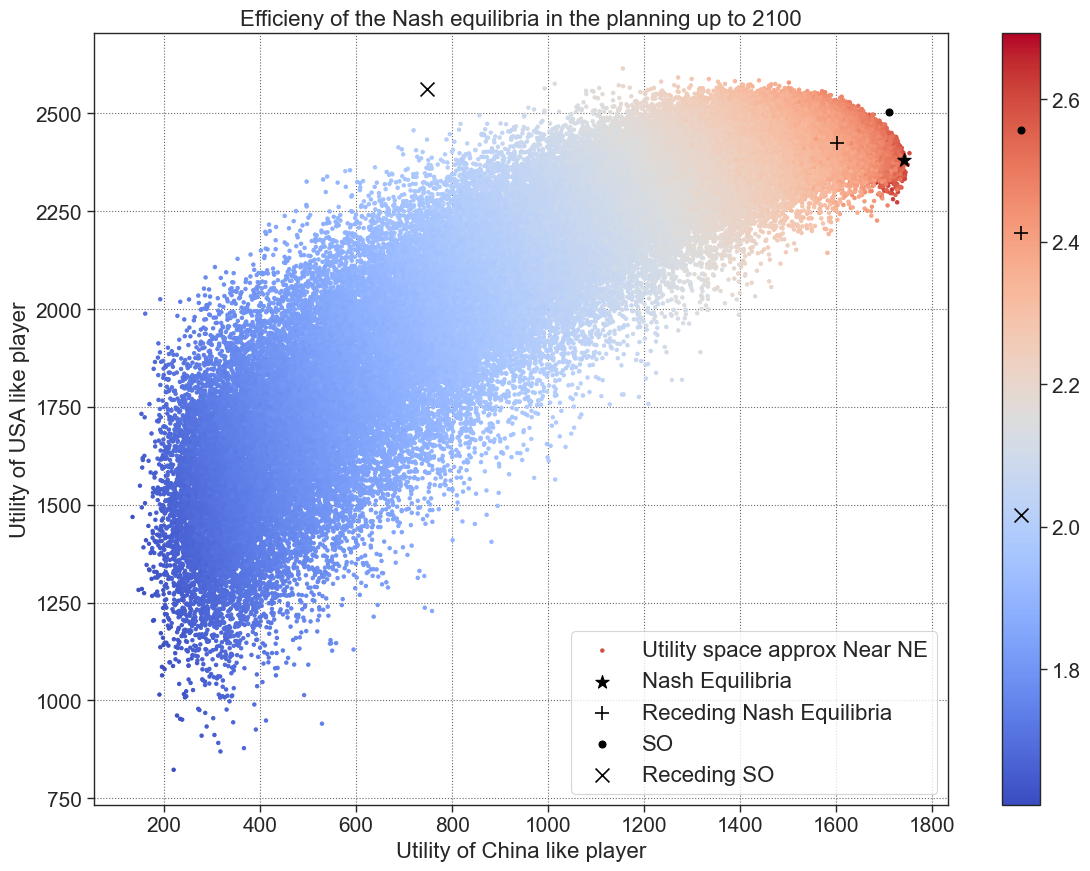

In [ ]:
fig = plt.figure(dpi = 100, figsize=(12,9))
ax = fig.gca()
p = ax.scatter(data_u[:,0], data_u[:,1], c=data_t[:,16],cmap='coolwarm', marker='.', label='Utility space approx Near NE')
cbar = fig.colorbar(p)

ax.scatter(u_p[0], u_p[1], marker='*', c='black', s=100, label='Nash Equilibria')
ax.scatter(u_r[0], u_r[1], marker='+', c='black',s=100, label='Receding Nash Equilibria')
ax.scatter(u_p_so[0], u_p_so[1], marker='.',c='black', s=100, label='SO')
ax.scatter(u_r_so[0], u_r_so[1], marker='x',c='black', s=100, label='Receding SO')
x_s = cbar.ax.set_xlim()
x_s = sum(x_s)/2
print(x_s)
ax.legend()

cbar.ax.scatter(x_s,temp_plan[16], marker='*', c='black', s=100, label='Nash Equilibria')
cbar.ax.scatter(x_s,temp_rece[16], marker='+', c='black',s=100, label='Receding Nash Equilibria')
cbar.ax.scatter(x_s,temp_plan_so[16], marker='.',c='black', s=100, label='SO')
cbar.ax.scatter(x_s,temp_rece_so[16], marker='x',c='black', s=100, label='Receding SO')

plt.xlabel('Utility of China like player')
plt.ylabel('Utility of USA like player')
plt.title('Efficieny of the Nash equilibria in the planning up to {}'.format(horizon))
plt.show()

In [31]:
np.save('sample', x)

NameError: name 'data_u' is not defined

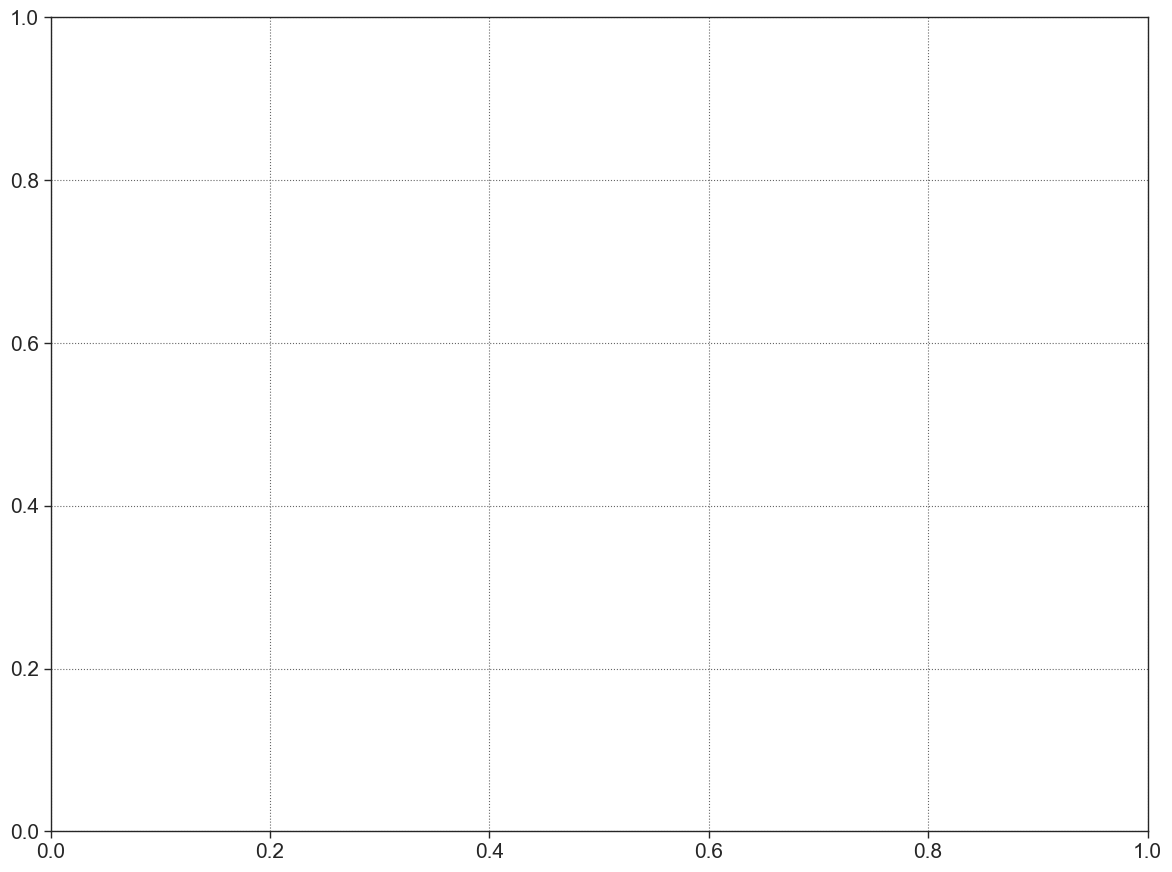

In [78]:
fig = plt.figure(dpi = 100, figsize=(12,9))
ax = fig.gca()
p = ax.scatter(data_u[:,0], data_u[:,1], c=data_t[:,16],cmap='coolwarm', marker='.', label='Utility space approx Near NE')
cbar = fig.colorbar(p)

p = ax.scatter(data_u[:,0], data_u[:,1], c=data_t[:,16],cmap='coolwarm', marker='.', label='Utility space approx Near NE')

ax.scatter(u_p[0], u_p[1], marker='*', c='black', s=100, label='Nash Equilibria')
ax.scatter(u_r[0], u_r[1], marker='+', c='black',s=100, label='Receding Nash Equilibria')
ax.scatter(u_p_so[0], u_p_so[1], marker='.',c='black', s=100, label='SO')
ax.scatter(u_r_so[0], u_r_so[1], marker='x',c='black', s=100, label='Receding SO')
x_s = cbar.ax.set_xlim()
x_s = sum(x_s)/2
print(x_s)
ax.legend()

cbar.ax.scatter(x_s,temp_plan[16], marker='*', c='black', s=100, label='Nash Equilibria')
cbar.ax.scatter(x_s,temp_rece[16], marker='+', c='black',s=100, label='Receding Nash Equilibria')
cbar.ax.scatter(x_s,temp_plan_so[16], marker='.',c='black', s=100, label='SO')
cbar.ax.scatter(x_s,temp_rece_so[16], marker='x',c='black', s=100, label='Receding SO')

plt.xlabel('Utility of China like player')
plt.ylabel('Utility of USA like player')
plt.title('Efficieny of the Nash equilibria in the planning up to {}'.format(horizon))
plt.show()
ax.scatter(u_p[0], u_p[1], marker='*', c='black', s=100, label='Nash Equilibria')
ax.scatter(u_r[0], u_r[1], marker='+', c='black',s=100, label='Receding Nash Equilibria')
ax.scatter(u_p_so[0], u_p_so[1], marker='.',c='black', s=100, label='SO')
ax.scatter(u_r_so[0], u_r_so[1], marker='x',c='black', s=100, label='Receding SO')
x_s = cbar.ax.set_xlim()
x_s = sum(x_s)/2
print(x_s)
ax.legend()

cbar.ax.scatter(x_s,temp_plan[16], marker='*', c='black', s=100, label='Nash Equilibria')
cbar.ax.scatter(x_s,temp_rece[16], marker='+', c='black',s=100, label='Receding Nash Equilibria')
cbar.ax.scatter(x_s,temp_plan_so[16], marker='.',c='black', s=100, label='SO')
cbar.ax.scatter(x_s,temp_rece_so[16], marker='x',c='black', s=100, label='Receding SO')

plt.xlabel('Utility of China like player')
plt.ylabel('Utility of USA like player')
plt.title('Efficieny of the Nash equilibria in the planning up to {}'.format(horizon))
plt.show()

C:\Users\Anthony Couthures\AppData\Local\Temp\ipykernel_30764\2719120300.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(p)


0.5


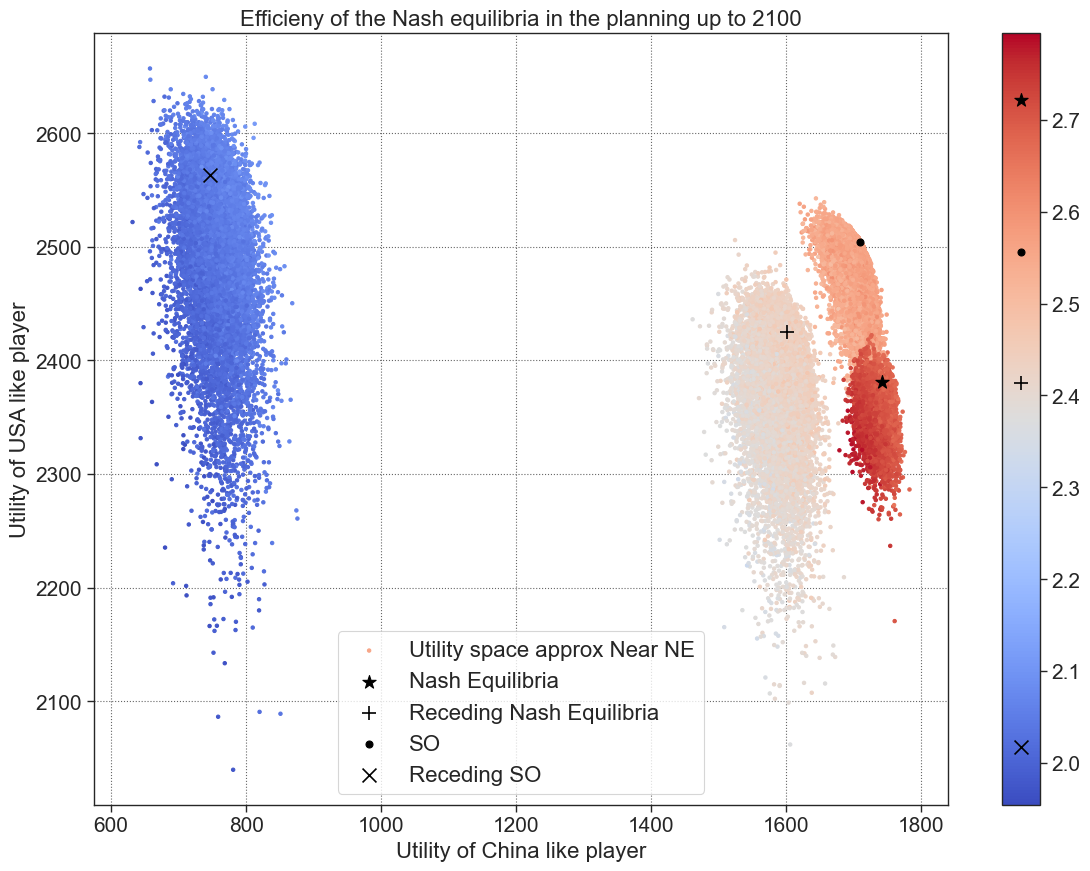

In [ ]:
fig = plt.figure(dpi = 100, figsize=(12,9))
ax = fig.gca()
p = ax.scatter(data_u[:,0], data_u[:,1], c=data_t[:,16],cmap='coolwarm', marker='.', label='Utility space approx Near NE')
cbar = fig.colorbar(p)

ax.scatter(u_p[0], u_p[1], marker='*', c='black', s=100, label='Nash Equilibria')
ax.scatter(u_r[0], u_r[1], marker='+', c='black',s=100, label='Receding Nash Equilibria')
ax.scatter(u_p_so[0], u_p_so[1], marker='.',c='black', s=100, label='SO')
ax.scatter(u_r_so[0], u_r_so[1], marker='x',c='black', s=100, label='Receding SO')
x_s = cbar.ax.set_xlim()
x_s = sum(x_s)/2
print(x_s)
ax.legend()

cbar.ax.scatter(x_s,temp_plan[16], marker='*', c='black', s=100, label='Nash Equilibria')
cbar.ax.scatter(x_s,temp_rece[16], marker='+', c='black',s=100, label='Receding Nash Equilibria')
cbar.ax.scatter(x_s,temp_plan_so[16], marker='.',c='black', s=100, label='SO')
cbar.ax.scatter(x_s,temp_rece_so[16], marker='x',c='black', s=100, label='Receding SO')

plt.xlabel('Utility of China like player')
plt.ylabel('Utility of USA like player')
plt.title('Efficieny of the Nash equilibria in the planning up to {}'.format(horizon))
plt.show()

In [ ]:
tuple_percentage = [percentage * ub for ub in action_sets[:,1]]
product_strategy = product(*tuple_percentage)
list_product_strategy = [list(x) for x in product_strategy]
random_product = []
for k in tqdm(range(num_sample), desc='Sampling'):
    random_product.append(random.choices(list_product_strategy, k= T))
random_product = np.array(random_product)
list_product_strategy_profile = np.moveaxis(random_product, [0,1,2], [0,2,1])
print(list_product_strategy_profile.shape)
data_utilities, data_actions_profiles = process(list_product_strategy_profile, SCM, list_players)

Sampling: 100%|██████████| 100000/100000 [00:00<00:00, 132667.95it/s]


(100000, 5, 17)


NameError: name 'list_players' is not defined

In [23]:
percentage = np.arange(k+1)/k


In [24]:
percentage

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [27]:
tuple_percentage = [percentage * ub for ub in action_sets[:,1]]


In [35]:
T = 3
ACTION_SETS =  np.array([[[0.0, 11.47],        # China  
                         [0.0, 5.01],         # USA
                         [0.0, 3.14],         # EU
                         [0.0, 2.71],         # India
                         [0.0, 1.76],         # Russia
                         [0.0, 13.51]]]*T)*2       # other 

np.swapaxes(ACTION_SETS,0,1).shape

(6, 3, 2)

In [272]:
import numpy as np

# Given array
arr = np.array([[[0.0, 22.94],
                [0.0, 22.94],
                [0.0, 22.94]],

               [[0.0, 10.02],
                [0.0, 10.02],
                [0.0, 10.02]],

               [[0.0, 6.28],
                [0.0, 6.28],
                [0.0, 6.28]],

               [[0.0, 5.42],
                [0.0, 5.42],
                [0.0, 5.42]],

               [[0.0, 3.52],
                [0.0, 3.52],
                [0.0, 3.52]],

               [[0.0, 27.02],
                [0.0, 27.02],
                [0.0, 27.02]]])

# Get lower and upper bounds from the last axis of the array
lower_bounds = arr[..., 0]
upper_bounds = arr[..., 1]

# Generate random vectors within the specified bounds
random_vectors = np.random.uniform(lower_bounds, upper_bounds, size=(100, arr.shape[0], arr.shape[1]))

print(random_vectors)

[[[1.68103565e+01 3.99571457e+00 2.75766146e+00]
  [6.34231635e+00 4.32001538e+00 7.50354047e+00]
  [5.43880188e+00 1.86351713e-01 6.26592662e-01]
  [1.36700905e+00 3.58132542e+00 3.55461593e+00]
  [1.89888706e+00 2.28666625e+00 2.52186555e+00]
  [1.44363867e+01 2.09083842e+01 9.78922559e-01]]

 [[6.06270437e-01 1.47051668e+01 1.47932310e+00]
  [1.02780978e+00 2.98978319e+00 7.67028154e+00]
  [4.87863766e+00 3.20939863e+00 3.04314771e+00]
  [4.85038492e+00 5.64268230e-03 4.22933400e-01]
  [3.39064601e-01 1.57437884e+00 2.77505548e+00]
  [3.56283909e+00 8.34121734e+00 1.94257229e+01]]

 [[1.72694147e+01 1.56615230e+01 7.42442443e+00]
  [5.36328709e+00 8.28205064e+00 1.21051260e+00]
  [3.68554970e+00 2.22879884e+00 1.03592773e+00]
  [3.42787590e+00 2.31601837e+00 6.05402473e-01]
  [1.86279882e+00 1.03802553e-01 1.44348702e+00]
  [2.23602237e+01 4.03340319e+00 2.97755211e-01]]

 ...

 [[8.01290042e+00 1.80555352e+01 9.39768874e-01]
  [1.83791575e-01 6.05437672e+00 9.79010866e+00]
  [2.215

In [118]:
upper_bounds

array([[22.94, 22.94, 22.94],
       [10.02, 10.02, 10.02],
       [ 6.28,  6.28,  6.28],
       [ 5.42,  5.42,  5.42],
       [ 3.52,  3.52,  3.52],
       [27.02, 27.02, 27.02]])

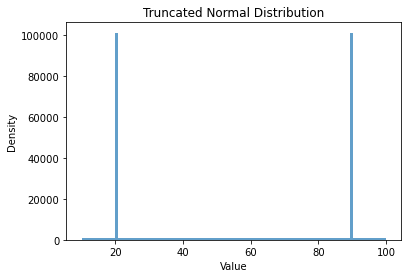

In [126]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import truncnorm, norm

# Set the boundaries and mean of the truncated normal distribution
a = 10  # Lower bound
b = 100  # Upper bound
mean =  2*a # (b-a) / 1000 # Mean close to the lower boundary
scale = 0
# Calculate the bounds for the standard normal distribution
lower_bound = (a - mean)   # Divide by standard deviation (1) to get z-score
upper_bound = (b - mean) 


# Generate a sample from the truncated normal distribution
size = 100000
samples = truncnorm.rvs(a, b, loc=mean, scale=scale, size=size, )
samples = np.concatenate((samples,a + b - truncnorm.rvs(a, b, loc=mean, scale=scale, size=size)), axis=0)
samples = np.concatenate((samples, a + (b-a) * stats.uniform.rvs(size=size)), axis=0)

# Plot the histogram of the samples
plt.hist(samples, bins=100,  alpha=0.7)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Truncated Normal Distribution')
plt.show()


In [181]:
import numpy as np

def invNormal(low : np.ndarray, high : np.ndarray, loc = None, scale=1, *, size=1, block_size=1024, random_state=None):
    remain = size
    result = []
    if not loc:
        loc = (high + low) / 2
    
    mul = -0.5 * scale**-2

    while remain:
        # draw next block of uniform variates within interval
        x = np.random.uniform(low, high, size=min((remain+5)*2, block_size))
        
        # reject proportional to normal density
        x = x[np.exp(mul*(x-loc)**2) < np.random.rand(*x.shape)]
        
        # make sure we don't add too much
        if remain < len(x):
            x = x[:remain]

        result.append(x)
        remain -= len(x)

    return np.concatenate(result)

In [182]:
from itertools import zip_longest
import numpy as np

def invNormal(low : np.ndarray, high : np.ndarray, loc = None, scale=1, *, size=1, block_size=1024, random_state=None):
    remain = size
    result = []
    if not loc:
        loc = (high + low) / 2
    
    mul = -0.5 * scale**-2

    while remain:
        # draw next block of uniform variates within interval
        x = np.random.uniform(low, high, size=min((remain+5)*2, block_size))
        
        # reject proportional to normal density
        x = x[np.exp(mul*(x-loc)**2) < np.random.rand(*x.shape)]
        
        # make sure we don't add too much
        if remain < len(x):
            x = x[:remain]

        result.append(x)
        remain -= len(x)

    return np.concatenate(result)

def _check_shape(argshape, size):
    """
    This is a utility function used by `_rvs()` in the class geninvgauss_gen.
    It compares the tuple argshape to the tuple size.

    Parameters
    ----------
    argshape : tuple of integers
        Shape of the arguments.
    size : tuple of integers or integer
        Size argument of rvs().

    Returns
    -------
    The function returns two tuples, scalar_shape and bc.

    scalar_shape : tuple
        Shape to which the 1-d array of random variates returned by
        _rvs_scalar() is converted when it is copied into the
        output array of _rvs().

    bc : tuple of booleans
        bc is an tuple the same length as size. bc[j] is True if the data
        associated with that index is generated in one call of _rvs_scalar().

    """
    scalar_shape = []
    bc = []
    for argdim, sizedim in zip_longest(argshape[::-1], size[::-1],
                                       fillvalue=1):
        if sizedim > argdim or (argdim == sizedim == 1):
            scalar_shape.append(sizedim)
            bc.append(True)
        else:
            bc.append(False)
    return tuple(scalar_shape[::-1]), tuple(bc[::-1])

def invNormal_rvs(a, b, loc = None, scale = 1, size=None, random_state=None):
    # if a and b are scalar, use _rvs_scalar, otherwise need to create
    # output by iterating over parameters
    if np.isscalar(a) and np.isscalar(b):
        out = invNormal(a, b, size, random_state=random_state)
    elif a.size == 1 and b.size == 1:
        out = invNormal(a.item(), b.item(), size,
                                random_state=random_state)
    else:
        # When this method is called, size will be a (possibly empty)
        # tuple of integers.  It will not be None; if `size=None` is passed
        # to `rvs()`, size will be the empty tuple ().

        a, b = np.broadcast_arrays(a, b)
        # a and b now have the same shape.

        # `shp` is the shape of the blocks of random variates that are
        # generated for each combination of parameters associated with
        # broadcasting a and b.
        # bc is a tuple the same length as size.  The values
        # in bc are bools.  If bc[j] is True, it means that
        # entire axis is filled in for a given combination of the
        # broadcast arguments.
        shp, bc = _check_shape(a.shape, size)

        # `numsamples` is the total number of variates to be generated
        # for each combination of the input arguments.
        numsamples = int(np.prod(shp))

        # `out` is the array to be returned.  It is filled in in the
        # loop below.
        out = np.empty(size)

        it = np.nditer([a, b],
                        flags=['multi_index'],
                        op_flags=[['readonly'], ['readonly']])
        while not it.finished:
            # Convert the iterator's multi_index into an index into the
            # `out` array where the call to _rvs_scalar() will be stored.
            # Where bc is True, we use a full slice; otherwise we use the
            # index value from it.multi_index.  len(it.multi_index) might
            # be less than len(bc), and in that case we want to align these
            # two sequences to the right, so the loop variable j runs from
            # -len(size) to 0.  This doesn't cause an IndexError, as
            # bc[j] will be True in those cases where it.multi_index[j]
            # would cause an IndexError.
            idx = tuple((it.multi_index[j] if not bc[j] else slice(None))
                        for j in range(-len(size), 0))
            out[idx] =  invNormal(it[0], it[1], loc=loc, scale=scale, size=numsamples,
                                        random_state = random_state).reshape(shp)
            it.iternext()

    if size == ():
        out = out.item()
    return out

In [183]:
def invNormal_rvs(a, b, loc = None, scale = 1, size=None, random_state=None):
    # if a and b are scalar, use _rvs_scalar, otherwise need to create
    # output by iterating over parameters
    if np.isscalar(a) and np.isscalar(b):
        out = invNormal(a, b, size, random_state=random_state)
    elif a.size == 1 and b.size == 1:
        out = invNormal(a.item(), b.item(), size,
                                random_state=random_state)
    else:
        # When this method is called, size will be a (possibly empty)
        # tuple of integers.  It will not be None; if `size=None` is passed
        # to `rvs()`, size will be the empty tuple ().

        a, b = np.broadcast_arrays(a, b)
        # a and b now have the same shape.

        # `shp` is the shape of the blocks of random variates that are
        # generated for each combination of parameters associated with
        # broadcasting a and b.
        # bc is a tuple the same length as size.  The values
        # in bc are bools.  If bc[j] is True, it means that
        # entire axis is filled in for a given combination of the
        # broadcast arguments.
        shp, bc = _check_shape(a.shape, size)

        # `numsamples` is the total number of variates to be generated
        # for each combination of the input arguments.
        numsamples = int(np.prod(shp))

        # `out` is the array to be returned.  It is filled in in the
        # loop below.
        out = np.empty(size)

        it = np.nditer([a, b],
                        flags=['multi_index'],
                        op_flags=[['readonly'], ['readonly']])
        while not it.finished:
            # Convert the iterator's multi_index into an index into the
            # `out` array where the call to _rvs_scalar() will be stored.
            # Where bc is True, we use a full slice; otherwise we use the
            # index value from it.multi_index.  len(it.multi_index) might
            # be less than len(bc), and in that case we want to align these
            # two sequences to the right, so the loop variable j runs from
            # -len(size) to 0.  This doesn't cause an IndexError, as
            # bc[j] will be True in those cases where it.multi_index[j]
            # would cause an IndexError.
            idx = tuple((it.multi_index[j] if not bc[j] else slice(None))
                        for j in range(-len(size), 0))
            out[idx] =  invNormal(it[0], it[1], loc=loc, scale=scale, size=numsamples,
                                        random_state = random_state).reshape(shp)
            it.iternext()

    if size == ():
        out = out.item()
    return out

In [187]:
random_vector[:,4,:].shape

(100000, 3)

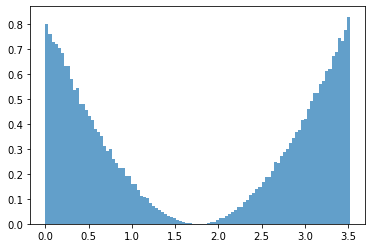

In [185]:
random_vector = invNormal_rvs(lower_bounds, upper_bounds, scale= 3, size=(100000, arr.shape[0], arr.shape[1]))
ax, fig = plt.figure()
plt.hist(random_vector[:,4,0], bins=100,  alpha=0.7, density=True)
plt.show()

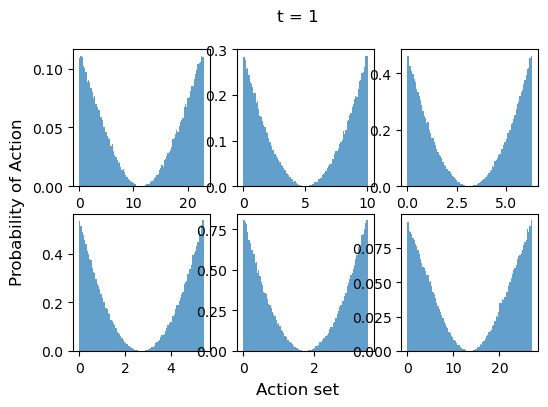

In [193]:
n_row = 2
n_col = 3
random_vector = invNormal_rvs(lower_bounds, upper_bounds, scale= 10, size=(100000, arr.shape[0], arr.shape[1]))

plt.rcParams["figure.autolayout"] = True

fig, axes = plt.subplots(n_row, n_col, dpi = 100, figsize=(12,9))
t = 0
k = 0
for row in range(n_row):
    for col in range(n_col):
        axes[row, col].hist(random_vector[:,k,t], bins=100,  alpha=0.7, density=True)
        k += 1
fig.supylabel('Probability of Action')
fig.supxlabel('Action set')

fig.suptitle('For t = {}'.format(t +1))

plt.show()


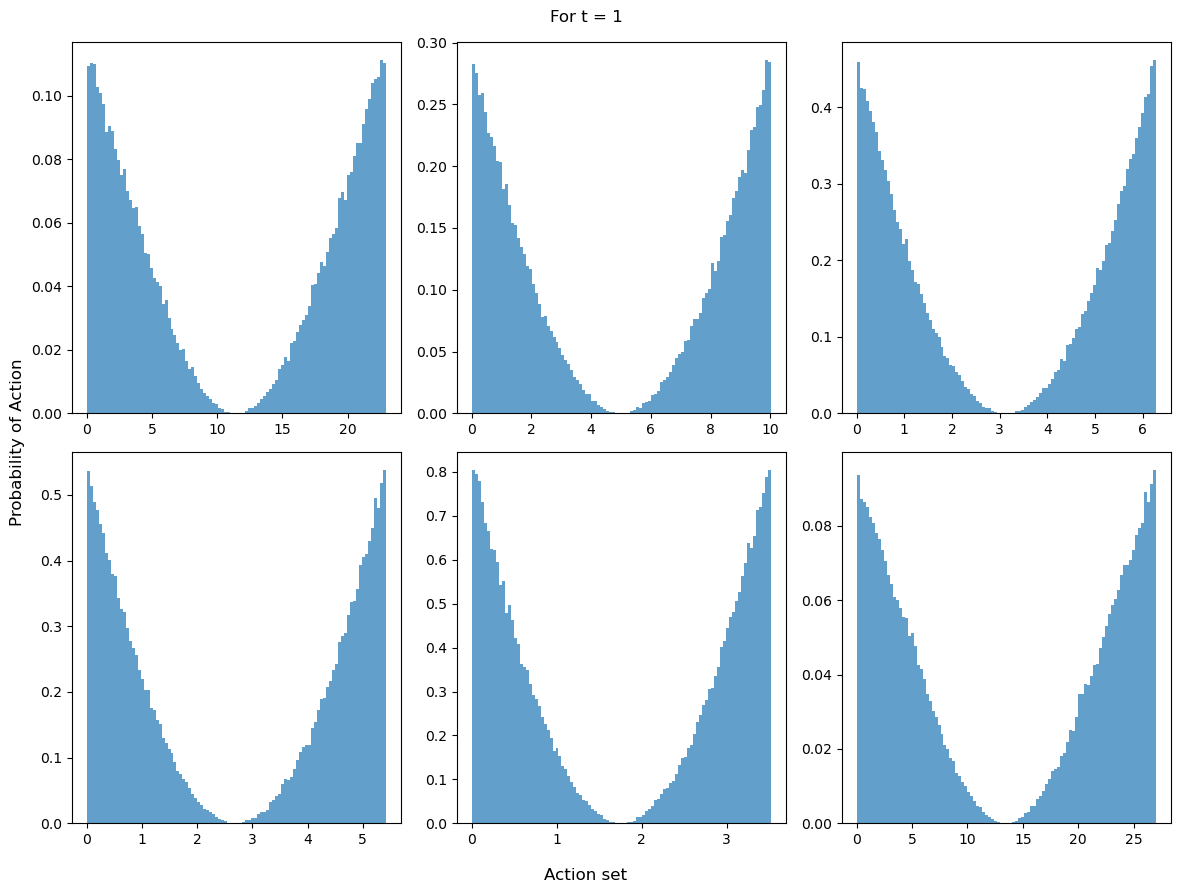

In [197]:
plt.rcParams["figure.autolayout"] = True

fig, axes = plt.subplots(n_row, n_col, dpi = 100, figsize=(12,9))
t = 0
k = 0
for row in range(n_row):
    for col in range(n_col):
        axes[row, col].hist(random_vector[:,k,t], bins=100,  alpha=0.7, density=True)
        k += 1
fig.supylabel('Probability of Action')
fig.supxlabel('Action set')

fig.suptitle('For t = {}'.format(t +1))

plt.show()

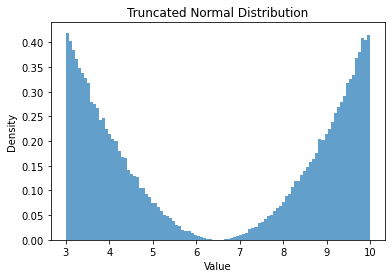

In [112]:

plt.hist(invNormal(3, 10,  sd=30, size=100_000), bins=100,  alpha=0.7, density=True)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Truncated Normal Distribution')
plt.show()

In [113]:
arr = np.array([[[0.0, 22.94],
                [0.0, 22.94],
                [0.0, 22.94]],

               [[0.0, 10.02],
                [0.0, 10.02],
                [0.0, 10.02]],

               [[0.0, 6.28],
                [0.0, 6.28],
                [0.0, 6.28]],

               [[0.0, 5.42],
                [0.0, 5.42],
                [0.0, 5.42]],

               [[0.0, 3.52],
                [0.0, 3.52],
                [0.0, 3.52]],

               [[0.0, 27.02],
                [0.0, 27.02],
                [0.0, 27.02]]])

# Get lower and upper bounds from the last axis of the array
lower_bounds = arr[..., 0]
upper_bounds = arr[..., 1]

In [26]:
ACTION_SETS.shape

(6, 34, 2)

In [19]:
tuple_percentage = [percentage * ub for ub in action_sets[:,1]]
product_strategy = product(*tuple_percentage)
list_product_strategy = [list(x) for x in product_strategy]
random_product = []
for k in tqdm(range(num_sample), desc='Sampling'):
    random_product.append(random.choices(list_product_strategy, k= T))
random_product = np.array(random_product)
list_product_strategy_profile = np.moveaxis(random_product, [0,1,2], [0,2,1])
print(list_product_strategy_profile.shape)
data_utilities, data_actions_profiles = process(list_product_strategy_profile, SCM, list_players)

Sampling: 100%|██████████| 100000/100000 [00:00<00:00, 132667.95it/s]


(100000, 5, 17)


NameError: name 'list_players' is not defined

In [ ]:
def process(list_product_strategy_profile, game : Game) : 
    data_utilities = []
    data_actions_profiles = []
    for strategy in tqdm(list_product_strategy_profile, 'Processing'):
        data_utilities.append(game.game_with_strategies_profile(strategy))
        data_utilities.append(game.strat_utilities_profiles)
        data_actions_profiles.append(game.strat_action_profiles)
    return data_utilities, data_actions_profiles

In [2]:
indice_1 = 0
indice_2 = 1

In [3]:
def process(list_product_strategy_profile, smc, list_players) : 
    data_utilities = []
    data_actions_profiles = []
    for strategy in tqdm(list_product_strategy_profile, 'Processing'):
        game = Game(deepcopy(smc), list_players)
        game.repeated_one_shot_game_with_strategies_profile(strategy)
        data_utilities.append(game.strat_utilities_profiles)
        data_actions_profiles.append(game.strat_action_profiles)
    return data_utilities, data_actions_profiles

def process_one_shot(list_product_strategy_profile, product_strategy_sum, smc, list_players) : 
    data_utilities = []
    for idx in tqdm(range(len(product_strategy_sum)), 'Processing'):
        strategy = list_product_strategy_profile[idx]
        strat_sum = product_strategy_sum[idx]
        game = Game(deepcopy(smc), list_players)
        utilities = game.one_shot_game_with_strategies_profile(strategy,strat_sum, smc)
        data_utilities.append(utilities)
    return data_utilities

def process_following(following, smc, list_players) : 
    data_follow_utilities = []
    data_follow_actions = []
    for time in range(T):
        data_utilities = []
        data_actions_profiles = []
        list_product_strategy_profile = following[time]
        for strategy in tqdm(list_product_strategy_profile, 'Processing'):
            game = Game(deepcopy(smc), list_players)
            game.repeated_one_shot_game_with_strategies_profile(strategy)
            data_utilities.append(game.strat_utilities_profiles)
            data_actions_profiles.append(game.strat_action_profiles)
        data_follow_utilities.append(data_utilities)
        data_follow_actions.append(data_actions_profiles)
    return data_follow_utilities, data_follow_actions



In [4]:
def pareto_domine(NE_utilities, strat_utilities):
    for i in range(len(NE_utilities)) :
        if NE_utilities[i] > strat_utilities[i] :
            return False
    return True

delta_step = 5

def pareto_domine_uptill_time(profile_NE_utilities, profile_strat_utilities, time):
    for t in range(time):
        if not pareto_domine(profile_NE_utilities[:,t], profile_strat_utilities[:,t]):
            return False
    return True 

def pareto_domine_over_delta(NE_utilities, strat_utilities, delta):
    for i in range(len(NE_utilities)) :
        tsup = min(i + delta, len(NE_utilities))
        if np.sum(NE_utilities[i:tsup]) > np.sum(strat_utilities[i:tsup]) :
            return False
    return True

def pareto_domine_over_time(profile_NE_utilities, profile_strat_utilities):
    n,tmax = np.shape(profile_NE_utilities)
    for time in range(tmax):
        if not pareto_domine(profile_NE_utilities[:,time], profile_strat_utilities[:,time]):
            return False
    return True 

def pareto_domine_sum_utility(NE_utilities, strat_utilities):
    for i in range(len(NE_utilities)) :
        if NE_utilities[i] > strat_utilities[i] :
            return False
    return True

In [5]:
def sort_data(data_u, data_a, utilities_NE) :
    pareto_strict_u = []
    pareto_strict_a = []
    pareto_sum_u = []
    pareto_sum_a = []

    for idx in range(len(data_u)):
        profile_u = data_u[idx]
        profile_a = data_a[idx]
        if pareto_domine_over_time(utilities_NE, profile_u):
            pareto_strict_u.append(profile_u)
            pareto_strict_a.append(profile_a)

        if pareto_domine_sum_utility(np.sum(utilities_NE,axis=1), np.sum(profile_u,axis=1)):
            pareto_sum_u.append(profile_u)
            pareto_sum_a.append(profile_a)

    pareto_up_u = []
    pareto_up_a = []
    for time in range(T):
        pareto_up_time_u = []
        pareto_up_time_a = []
        for idx in range(len(data_u)):
            profile_u = data_u[idx]
            profile_a = data_u[idx]

            if pareto_domine_uptill_time(utilities_NE, profile_u, time+1):
                pareto_up_time_u.append(profile_u)
                pareto_up_time_a.append(profile_a)

        pareto_up_u.append(pareto_up_time_u)
        pareto_up_a.append(pareto_up_time_a)

    print('Num strat Pareto every step :', len(pareto_strict_u))
    print('Num strat Pareto in sum :', len(pareto_sum_u))

    return pareto_strict_u, pareto_strict_a, pareto_sum_u, pareto_sum_a


def sort_follow(following_u, following_a, utilities_NE):
    pareto_at_u = []
    pareto_at_a = []
    pareto_delta_u = []
    pareto_delta_a = []
    pareto_sum_u = []
    pareto_sum_a = []
    for time in range(T):

        data_u = following_u[time]
        data_a = following_a[time]

        pareto_at_time_u = []
        pareto_at_time_a = []
        pareto_delta_time_u = []
        pareto_delta_time_a = []
        pareto_sum_time_u = []
        pareto_sum_time_a = []

        for idx in range(len(data_u)):
            profile_u = data_u[idx]
            profile_a = data_a[idx]
            if pareto_domine(utilities_NE[:,time], profile_u[:,time]):
                pareto_at_time_u.append(profile_u)
                pareto_at_time_a.append(profile_a)

            if pareto_domine_over_delta(utilities_NE, profile_u, delta=delta_step):
                pareto_delta_time_u.append(profile_u)
                pareto_delta_time_a.append(profile_a)

            if pareto_domine_sum_utility(np.sum(utilities_NE,axis=1), np.sum(profile_u,axis=1)):
                pareto_sum_time_u.append(profile_u)
                pareto_sum_time_a.append(profile_a)

        pareto_at_u.append(pareto_at_time_u)
        pareto_at_a.append(pareto_at_time_a)
        pareto_delta_u.append(pareto_delta_time_u)
        pareto_delta_a.append(pareto_delta_time_a)
        pareto_sum_u.append(pareto_sum_time_u)
        pareto_sum_a.append(pareto_sum_time_a)

    return pareto_at_u, pareto_at_a, pareto_delta_u, pareto_delta_a, pareto_sum_u, pareto_sum_a 


def sort_one_shot(strat_u, strat_a, list_utilities_NE):
    pareto_at_u = []
    pareto_at_a = []

    for idx in range(len(strat_u)):

        data_u = strat_u[idx]
        data_a = strat_a[idx]
        utilities_NE = list_utilities_NE[idx]

        pareto_at_time_u = []
        pareto_at_time_a = []

        for idx_ in range(len(data_u)):
            profile_u = data_u[idx_]
            profile_a = data_a[idx_]
            if pareto_domine(utilities_NE, profile_u):
                pareto_at_time_u.append(profile_u)
                pareto_at_time_a.append(profile_a)

        pareto_at_u.append(pareto_at_time_u)
        pareto_at_a.append(pareto_at_time_a)


    return pareto_at_u, pareto_at_a

In [6]:
from matplotlib import hatch




def fill_convex_hull(p_1, p_2, color, label):
    points = np.array([p_1,p_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c=color, lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], c=color,  alpha=0.3, label=label)

def hatch_convex_hull(p_1, p_2, color, label, hatch ='/'):
    points = np.array([p_1,p_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c=color, lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], color="none", hatch=hatch ,edgecolor=color, alpha=0.3, label=label)

def plot_utilities_merged_temp(data_utilities, list_temp, list_pareto, list_utilities_NE):
    plt.figure(figsize=(8,8),dpi=120)
    k = len(list_temp)
    colors = sns.color_palette("rocket",k)
    c = 0
    for idx in range(0,k):
        feasible_u = data_utilities[idx]
        utilities_NE = list_utilities_NE[idx]
        temp = list_temp[idx]
        pareto = list_pareto[idx]
        p_1 = [profile[indice_1] for profile in feasible_u]
        p_2 = [profile[indice_2] for profile in feasible_u]
        fill_convex_hull(p_1, p_2, colors[c], 'Feasible utilities at temp {}'.format(temp))
        plt.scatter(utilities_NE[indice_1], utilities_NE[indice_2], color=colors[c], zorder=10, label ='NE at temp {}'.format(temp), marker='X',s=90, edgecolor='black')

        try :
            p_1 = [profile[indice_1] for profile in pareto]
            p_2 = [profile[indice_2] for profile in pareto]
            plt.scatter(p_1,p_2,c='black',marker='*', alpha=0.9)

            hatch_convex_hull(p_1, p_2, 'black', 'Convex hull of pareto utilities at temp {}'.format(temp))
        except:
            pass
        # plt.scatter(p_1,p_2, alpha=0.4)
        c += 1


    plt.xlabel('Utility player {}'.format(indice_1+1))
    plt.ylabel('Utility player {}'.format(indice_2+1))
    plt.legend()
    plt.title('Evolution of utility space  for player {} and {} with respect to temperature'.format( indice_1+1, indice_2+1))
    plt.show()

def plot_utilities_merged(feasible_u, utilities_NE):
    plt.figure(figsize=(8,8),dpi=120)
    colors = sns.color_palette("rocket",T//2+1)
    c = 0
    for time in range(0,T, 2):
        p_1 = [profile[indice_1,time] for profile in feasible_u]
        p_2 = [profile[indice_2,time] for profile in feasible_u]
        fill_convex_hull(p_1, p_2, colors[c], 'Feasible utilities at time {}'.format(time * 5 +2020))
        plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], color=colors[c], zorder=10, label ='NE at time {}'.format(time *5 + 2020), marker='X',s=90, edgecolor='black')

        # plt.scatter(p_1,p_2, alpha=0.4)
        c += 1


    plt.xlabel('Utility player {}'.format(indice_1+1))
    plt.ylabel('Utility player {}'.format(indice_2+1))
    plt.legend()
    plt.title('Evolution of utility space for strategy over {} to {} for player {} and {}'.format(FIRST_YEAR, FINAL_YEAR, indice_1+1, indice_2+1))
    plt.show()

def plot_utilities_space(following, utilities_NE, pareto_delta_u, pareto_dominant_sum_utilities, pareto_dominant_strict_utilities, pareto_dominant_at) :
    colors = sns.color_palette("tab10")
    for time in range(0,T, 2):
        plt.figure(figsize=(6,6),dpi=120)

        ## Feasible set 
        try :
            p_1 = [profile[indice_1,time] for profile in following[time]]
            p_2 = [profile[indice_2,time] for profile in following[time]]
            # plt.scatter(p_1,p_2,c='b', alpha=0.9)

            fill_convex_hull(p_1, p_2, 'b', 'Convex hull of feasible utilities')
        except:
            pass
        
        ## Sum optimal
        try :        
            p_1 = [profile[indice_1,time] for profile in pareto_dominant_sum_utilities[time]]
            p_2 = [profile[indice_2,time] for profile in pareto_dominant_sum_utilities[time]]

            fill_convex_hull(p_1, p_2, 'brown', 'Convex hull sum utilities btw {} and {} dominant'.format(FIRST_YEAR, FINAL_YEAR))
            # plt.scatter(p_1,p_2,c='brown', alpha=0.9)
        except:
            pass

        ## Delta_optimal 
        try :
            p_1 = [profile[indice_1,time] for profile in pareto_delta_u[time]]
            p_2 = [profile[indice_2,time] for profile in pareto_delta_u[time]]

            fill_convex_hull(p_1, p_2, 'orange', 'Convex hull utilities sum over {} years dominant'.format(delta_step*5 ))
            # plt.scatter(p_1,p_2,c='orange', alpha=0.9)
        except:
            pass      

        try :
            p_1 = [profile[indice_1,time] for profile in pareto_dominant_strict_utilities]
            p_2 = [profile[indice_2,time] for profile in pareto_dominant_strict_utilities]
            fill_convex_hull(p_1, p_2, 'yellow', 'Convex hull utilities dominant at every time')
            # plt.scatter(p_1,p_2,c='yellow', alpha=0.9)
        except:
            pass

        try :
            p_1 = [profile[indice_1,time] for profile in pareto_dominant_at[time]]
            p_2 = [profile[indice_2,time] for profile in pareto_dominant_at[time]]
            hatch_convex_hull(p_1, p_2, 'black', 'Pareto dominant utilities', hatch= '/' )
            plt.scatter(p_1,p_2,c='black', marker='*', s=10, alpha=0.9)
        except:
            pass
        
        plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], label ='NE', marker='+',s=10,c='black', edgecolor='black')
        plt.xlabel('Utility player {}'.format(indice_1+1))
        plt.ylabel('Utility player {}'.format(indice_2+1)) 
        plt.title('Utilities of player {} and {} at {}'.format(indice_1+1, indice_2+1, 2020 + time *5))
        plt.legend()
        plt.show()



# Changement de l'état

In [ ]:
list_players = create_players(alpha=1, list_benefit_functions=list_list_benefit_functions[0], damage_function=damage_polynome(list_damage_coef[0]), discount=1)

game = Game(list_players, horizon=horizon, temperature_target= temperature_target, final_multiplier=final_multiplier)

In [ ]:
plt.figure(figsize=(8,8),dpi=120)
colors = sns.color_palette("rocket",T//4+1)
c = 0
for time in range(0,T, 4):
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c=colors[c], lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], c=colors[c] , alpha=0.3)

    # plt.scatter(scatter_indice_1,scatter_indice_2, alpha=0.4)
    c += 1

plt.gca().set_prop_cycle(None)
c = 0

for time in range(0,T, 4):

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], color=colors[c], label ='NE', marker='X',s=90, edgecolor='black')
    c += 1

plt.legend()
plt.show()

In [ ]:
pareto_domiant_strict_utilities = []
pareto_domiant_delta_utilities = []
pareto_domiant_sum_utilities = []

pareto_domiant_strict_actions_profiles = []
pareto_domiant_delta_actions_profiles = []
pareto_domiant_sum_actions_profiles = []


for idx in range(len(data_utilities)):
    profile_strat_utilities = data_utilities[idx]
    if pareto_domine_over_time(utilities_NE, profile_strat_utilities):
        pareto_domiant_strict_utilities.append(profile_strat_utilities)
        pareto_domiant_strict_actions_profiles.append(data_actions_profiles[idx])

    if pareto_domine_over_delta(utilities_NE, profile_strat_utilities, delta=delta_step):
        pareto_domiant_delta_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])
    if pareto_domine_sum_utility(np.sum(utilities_NE,axis=1), np.sum(profile_strat_utilities,axis=1)):
        pareto_domiant_sum_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])

print('Num strat Pareto every step :', len(pareto_domiant_strict_utilities))
print('Num strat Pareto over {} steps :'.format(delta_step), len(pareto_domiant_delta_utilities))
print('Num strat Pareto in sum :', len(pareto_domiant_sum_utilities))

In [ ]:


colors = sns.color_palette("tab10")
for time in range(0,T, 4):
    plt.figure(figsize=(6,6),dpi=120)
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    plt.scatter(scatter_indice_1,scatter_indice_2,c='b', alpha=0.1)

    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='b', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'b', alpha=0.3,label ='convex hull utilities')


    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_delta_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_delta_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='orange', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'orange', alpha=0.3,label ='convex hull sum over {} step dominant'.format(delta_step))
    plt.scatter(scatter_indice_1,scatter_indice_2,c='orange', alpha=0.1)
    
    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_sum_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_sum_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
    plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.1)
    c += 1

    try :
        scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_strict_utilities]
        scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_strict_utilities]
        points = np.array([scatter_indice_1,scatter_indice_2]).T
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
        plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
        plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.1)
        c += 1
    except:
        pass

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], label ='NE', marker='X',s=90,c='black', edgecolor='black')
    plt.legend()
    plt.show()


In [ ]:


plt.figure(figsize=(8,8),dpi=120)
colors = sns.color_palette("rocket",T//4+1)
c = 0
for time in range(0,T, 4):
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    plt.scatter(scatter_indice_1,scatter_indice_2, alpha=0.4)

    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_delta_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_delta_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c=colors[c], lw = .7)
    plt.scatter(scatter_indice_1,scatter_indice_2, alpha=0.4)
    c += 1

plt.gca().set_prop_cycle(None)
for time in range(0,T, 4):

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], label ='NE', marker='X',s=90, edgecolor='black')
plt.legend()
plt.show()


## Benefit fixed Convexe

In [ ]:
list_benef_function = [benefit_quadratic_convex_with_percentage_green(gdp_max[i], action_sets[i,1], percentage_green=0.3) for i in range(N)]

In [ ]:
list_players = [player_class(name = 'player {}'.format(i), action_set = action_sets[i], smc = deepcopy(smc),
                                benefit_function = benefit_quadratic_concave_with_percentage_green(gdp_max[i], action_sets[i][1], percentage_green=0.2),
                                damage_function = damage_function,
                                impact_factor_of_temperature = deltas[i],
                                alpha=alpha) for i in range(N)]

game = Game(deepcopy(smc), list_players)
game.repeated_one_shot_game()
utilities_NE = game.utilities_profiles
actions_NE = game.action_profiles

## Discretisation en 0\%, 50\% et 100\%

In [ ]:
percentage = np.array([0, 5, 10])/10
tuple_percentage = [percentage * ub for ub in action_sets[:,1]]
product_strategy = product(*tuple_percentage)

list_product_strategy = np.array([list(x) for x in product_strategy], ndmin=3)
list_product_strategy_profile = np.moveaxis(np.moveaxis(np.repeat(list_product_strategy, repeats=T, axis=0), [0,1,2],[1,0,2]), [0,1,2], [0,2,1])
print(list_product_strategy_profile.shape)
data_utilities, data_actions_profiles = process(list_product_strategy_profile, smc, list_players)

In [ ]:
plt.figure(figsize=(8,8),dpi=120)
colors = sns.color_palette("rocket",T//4+1)
c = 0
for time in range(0,T, 4):
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c=colors[c], lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], c=colors[c] , alpha=0.3)

    # plt.scatter(scatter_indice_1,scatter_indice_2, alpha=0.4)
    c += 1

plt.gca().set_prop_cycle(None)
c = 0

for time in range(0,T, 4):

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], color=colors[c], label ='NE', marker='X',s=90, edgecolor='black')
    c += 1

plt.legend()
plt.show()

In [ ]:
pareto_domiant_strict_utilities = []
pareto_domiant_delta_utilities = []
pareto_domiant_sum_utilities = []

pareto_domiant_strict_actions_profiles = []
pareto_domiant_delta_actions_profiles = []
pareto_domiant_sum_actions_profiles = []


for idx in range(len(data_utilities)):
    profile_strat_utilities = data_utilities[idx]
    if pareto_domine_over_time(utilities_NE, profile_strat_utilities):
        pareto_domiant_strict_utilities.append(profile_strat_utilities)
        pareto_domiant_strict_actions_profiles.append(data_actions_profiles[idx])

    if pareto_domine_over_delta(utilities_NE, profile_strat_utilities, delta=delta_step):
        pareto_domiant_delta_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])
    if pareto_domine_sum_utility(np.sum(utilities_NE,axis=1), np.sum(profile_strat_utilities,axis=1)):
        pareto_domiant_sum_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])

print('Num strat Pareto every step :', len(pareto_domiant_strict_utilities))
print('Num strat Pareto over {} steps :'.format(delta_step), len(pareto_domiant_delta_utilities))
print('Num strat Pareto in sum :', len(pareto_domiant_sum_utilities))

In [ ]:


colors = sns.color_palette("tab10")
for time in range(0,T, 4):
    plt.figure(figsize=(6,6),dpi=120)
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    plt.scatter(scatter_indice_1,scatter_indice_2,c='b', alpha=0.9)

    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='b', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'b', alpha=0.3,label ='convex hull utilities')


    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_delta_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_delta_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='orange', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'orange', alpha=0.3,label ='convex hull sum over {} step dominant'.format(delta_step))
    plt.scatter(scatter_indice_1,scatter_indice_2,c='orange', alpha=0.9)
    
    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_sum_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_sum_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
    plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.9)
    c += 1

    try :
        scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_sum_utilities]
        scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_sum_utilities]
        points = np.array([scatter_indice_1,scatter_indice_2]).T
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
        plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
        plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.9)
        c += 1
    except:
        pass

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], label ='NE', marker='X',s=90,c='black', edgecolor='black')
    plt.legend()
    plt.show()


## Discretisation en 0\%, 50\% et 100\%

In [ ]:
percentage = np.array([0, 2, 4, 6, 8, 10])/10

tuple_percentage = [percentage * ub for ub in action_sets[:,1]]
product_strategy = product(*tuple_percentage)

list_product_strategy = np.array([list(x) for x in product_strategy], ndmin=3)
list_product_strategy_profile = np.moveaxis(np.moveaxis(np.repeat(list_product_strategy, repeats=T, axis=0), [0,1,2],[1,0,2]), [0,1,2], [0,2,1])
print(list_product_strategy_profile.shape)
data_utilities, data_actions_profiles = process(list_product_strategy_profile, smc, list_players)

In [ ]:
plt.figure(figsize=(8,8),dpi=120)
colors = sns.color_palette("rocket",T//4+1)
c = 0
for time in range(0,T, 4):
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c=colors[c], lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], c=colors[c] , alpha=0.3)

    # plt.scatter(scatter_indice_1,scatter_indice_2, alpha=0.4)
    c += 1

plt.gca().set_prop_cycle(None)
c = 0

for time in range(0,T, 4):

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], color=colors[c], label ='NE', marker='X',s=90, edgecolor='black')
    c += 1

plt.legend()
plt.show()

In [ ]:
pareto_domiant_strict_utilities = []
pareto_domiant_delta_utilities = []
pareto_domiant_sum_utilities = []

pareto_domiant_strict_actions_profiles = []
pareto_domiant_delta_actions_profiles = []
pareto_domiant_sum_actions_profiles = []


for idx in range(len(data_utilities)):
    profile_strat_utilities = data_utilities[idx]
    if pareto_domine_over_time(utilities_NE, profile_strat_utilities):
        pareto_domiant_strict_utilities.append(profile_strat_utilities)
        pareto_domiant_strict_actions_profiles.append(data_actions_profiles[idx])

    if pareto_domine_over_delta(utilities_NE, profile_strat_utilities, delta=delta_step):
        pareto_domiant_delta_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])
    if pareto_domine_sum_utility(np.sum(utilities_NE,axis=1), np.sum(profile_strat_utilities,axis=1)):
        pareto_domiant_sum_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])

print('Num strat Pareto every step :', len(pareto_domiant_strict_utilities))
print('Num strat Pareto over {} steps :'.format(delta_step), len(pareto_domiant_delta_utilities))
print('Num strat Pareto in sum :', len(pareto_domiant_sum_utilities))

In [ ]:


colors = sns.color_palette("tab10")
for time in range(0,T, 4):
    plt.figure(figsize=(6,6),dpi=120)
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    plt.scatter(scatter_indice_1,scatter_indice_2,c='b', alpha=0.9)

    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='b', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'b', alpha=0.3,label ='convex hull utilities')


    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_delta_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_delta_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='orange', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'orange', alpha=0.3,label ='convex hull sum over {} step dominant'.format(delta_step))
    plt.scatter(scatter_indice_1,scatter_indice_2,c='orange', alpha=0.9)
    
    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_sum_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_sum_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
    plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.9)
    c += 1

    try :
        scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_sum_utilities]
        scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_sum_utilities]
        points = np.array([scatter_indice_1,scatter_indice_2]).T
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
        plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
        plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.9)
        c += 1
    except:
        pass

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], label ='NE', marker='X',s=90,c='black', edgecolor='black')
    plt.legend()
    plt.show()


## Discretisation en 0\%, 50\% et 100\%

In [ ]:
percentage = np.array([0, 1, 2, 3,  4, 5,  6, 7,  8, 9, 10])/10
tuple_percentage = [percentage * ub for ub in action_sets[:,1]]
product_strategy = product(*tuple_percentage)

list_product_strategy = np.array([list(x) for x in product_strategy], ndmin=3)
list_product_strategy_profile = np.moveaxis(np.moveaxis(np.repeat(list_product_strategy, repeats=T, axis=0), [0,1,2],[1,0,2]), [0,1,2], [0,2,1])
print(list_product_strategy_profile.shape)
data_utilities, data_actions_profiles = process(list_product_strategy_profile, smc, list_players)

In [ ]:
plt.figure(figsize=(8,8),dpi=120)
colors = sns.color_palette("rocket",T//4+1)
c = 0
for time in range(0,T, 4):
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c=colors[c], lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], c=colors[c] , alpha=0.3)

    # plt.scatter(scatter_indice_1,scatter_indice_2, alpha=0.4)
    c += 1

plt.gca().set_prop_cycle(None)
c = 0

for time in range(0,T, 4):

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], color=colors[c], label ='NE', marker='X',s=90, edgecolor='black')
    c += 1

plt.legend()
plt.show()

In [ ]:
pareto_domiant_strict_utilities = []
pareto_domiant_delta_utilities = []
pareto_domiant_sum_utilities = []

pareto_domiant_strict_actions_profiles = []
pareto_domiant_delta_actions_profiles = []
pareto_domiant_sum_actions_profiles = []


for idx in range(len(data_utilities)):
    profile_strat_utilities = data_utilities[idx]
    if pareto_domine_over_time(utilities_NE, profile_strat_utilities):
        pareto_domiant_strict_utilities.append(profile_strat_utilities)
        pareto_domiant_strict_actions_profiles.append(data_actions_profiles[idx])

    if pareto_domine_over_delta(utilities_NE, profile_strat_utilities, delta=delta_step):
        pareto_domiant_delta_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])
    if pareto_domine_sum_utility(np.sum(utilities_NE,axis=1), np.sum(profile_strat_utilities,axis=1)):
        pareto_domiant_sum_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])

print('Num strat Pareto every step :', len(pareto_domiant_strict_utilities))
print('Num strat Pareto over {} steps :'.format(delta_step), len(pareto_domiant_delta_utilities))
print('Num strat Pareto in sum :', len(pareto_domiant_sum_utilities))

In [ ]:


colors = sns.color_palette("tab10")
for time in range(0,T, 4):
    plt.figure(figsize=(6,6),dpi=120)
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    plt.scatter(scatter_indice_1,scatter_indice_2,c='b', alpha=0.1)

    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='b', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'b', alpha=0.3,label ='convex hull utilities')


    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_delta_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_delta_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='orange', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'orange', alpha=0.3,label ='convex hull sum over {} step dominant'.format(delta_step))
    plt.scatter(scatter_indice_1,scatter_indice_2,c='orange', alpha=0.1)
    
    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_sum_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_sum_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
    plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.1)
    c += 1

    try :
        scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_strict_utilities]
        scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_strict_utilities]
        points = np.array([scatter_indice_1,scatter_indice_2]).T
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
        plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
        plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.1)
        c += 1
    except:
        pass

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], label ='NE', marker='X',s=90,c='black', edgecolor='black')
    plt.legend()
    plt.show()


# Action randomized

In [ ]:
k = 10
num_sample = 100000

In [ ]:
percentage

In [ ]:
percentage = np.arange(k+1)/k
tuple_percentage = [percentage * ub for ub in action_sets[:,1]]
product_strategy = product(*tuple_percentage)
list_product_strategy = [list(x) for x in product_strategy]
random_product = []
for k in tqdm(range(num_sample), desc='Sampling'):
    random_product.append(random.choices(list_product_strategy, k= T))
random_product = np.array(random_product)
list_product_strategy_profile = np.moveaxis(random_product, [0,1,2], [0,2,1])
print(list_product_strategy_profile.shape)
data_utilities, data_actions_profiles = process(list_product_strategy_profile, smc, list_players)

In [ ]:
plt.figure(figsize=(8,8),dpi=120)
colors = sns.color_palette("rocket",T//4+1)
c = 0
for time in range(0,T, 4):
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c=colors[c], lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], c=colors[c] , alpha=0.3)

    # plt.scatter(scatter_indice_1,scatter_indice_2, alpha=0.4)
    c += 1

plt.gca().set_prop_cycle(None)
c = 0

for time in range(0,T, 4):

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], color=colors[c], label ='NE', marker='X',s=90, edgecolor='black')
    c += 1

plt.legend()
plt.show()

In [ ]:
pareto_domiant_strict_utilities = []
pareto_domiant_delta_utilities = []
pareto_domiant_sum_utilities = []

pareto_domiant_strict_actions_profiles = []
pareto_domiant_delta_actions_profiles = []
pareto_domiant_sum_actions_profiles = []


for idx in range(len(data_utilities)):
    profile_strat_utilities = data_utilities[idx]
    if pareto_domine_over_time(utilities_NE, profile_strat_utilities):
        pareto_domiant_strict_utilities.append(profile_strat_utilities)
        pareto_domiant_strict_actions_profiles.append(data_actions_profiles[idx])

    if pareto_domine_over_delta(utilities_NE, profile_strat_utilities, delta=delta_step):
        pareto_domiant_delta_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])
    if pareto_domine_sum_utility(np.sum(utilities_NE,axis=1), np.sum(profile_strat_utilities,axis=1)):
        pareto_domiant_sum_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])

print('Num strat Pareto every step :', len(pareto_domiant_strict_utilities))
print('Num strat Pareto over {} steps :'.format(delta_step), len(pareto_domiant_delta_utilities))
print('Num strat Pareto in sum :', len(pareto_domiant_sum_utilities))

In [ ]:


colors = sns.color_palette("tab10")
for time in range(0,T, 4):
    plt.figure(figsize=(6,6),dpi=120)
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    plt.scatter(scatter_indice_1,scatter_indice_2,c='b', alpha=0.1)

    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='b', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'b', alpha=0.3,label ='convex hull utilities')


    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_delta_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_delta_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='orange', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'orange', alpha=0.3,label ='convex hull sum over {} step dominant'.format(delta_step))
    plt.scatter(scatter_indice_1,scatter_indice_2,c='orange', alpha=0.1)
    
    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_sum_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_sum_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
    plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.1)
    c += 1

    try :
        scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_strict_utilities]
        scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_strict_utilities]
        points = np.array([scatter_indice_1,scatter_indice_2]).T
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
        plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
        plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.1)
        c += 1
    except:
        pass

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], label ='NE', marker='X',s=90,c='black', edgecolor='black')
    plt.legend()
    plt.show()


## Benefit fixed Sigmoid

In [ ]:
list_benef_function = [benefice_sigm(gdp_max[i], action_sets[i,1], power=10) for i in range(N)]

In [ ]:
list_players = [player_class(name = 'player {}'.format(i), action_set = action_sets[i], smc = deepcopy(smc),
                                benefit_function = benefit_quadratic_concave_with_percentage_green(gdp_max[i], action_sets[i][1], percentage_green=0.2),
                                damage_function = damage_function,
                                impact_factor_of_temperature = deltas[i],
                                alpha=alpha) for i in range(N)]

game = Game(deepcopy(smc), list_players)
game.repeated_one_shot_game()
utilities_NE = game.utilities_profiles
actions_NE = game.action_profiles

## Discretisation en 0\%, 50\% et 100\%

In [ ]:
percentage = np.array([0, 5, 10])/10
tuple_percentage = [percentage * ub for ub in action_sets[:,1]]
product_strategy = product(*tuple_percentage)

list_product_strategy = np.array([list(x) for x in product_strategy], ndmin=3)
list_product_strategy_profile = np.moveaxis(np.moveaxis(np.repeat(list_product_strategy, repeats=T, axis=0), [0,1,2],[1,0,2]), [0,1,2], [0,2,1])
print(list_product_strategy_profile.shape)
data_utilities, data_actions_profiles = process(list_product_strategy_profile, smc, list_players)

In [ ]:
plt.figure(figsize=(8,8),dpi=120)
colors = sns.color_palette("rocket",T//4+1)
c = 0
for time in range(0,T, 4):
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c=colors[c], lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], c=colors[c] , alpha=0.3)

    # plt.scatter(scatter_indice_1,scatter_indice_2, alpha=0.4)
    c += 1

plt.gca().set_prop_cycle(None)
c = 0

for time in range(0,T, 4):

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], color=colors[c], label ='NE', marker='X',s=90, edgecolor='black')
    c += 1

plt.legend()
plt.show()

In [ ]:
pareto_domiant_strict_utilities = []
pareto_domiant_delta_utilities = []
pareto_domiant_sum_utilities = []

pareto_domiant_strict_actions_profiles = []
pareto_domiant_delta_actions_profiles = []
pareto_domiant_sum_actions_profiles = []


for idx in range(len(data_utilities)):
    profile_strat_utilities = data_utilities[idx]
    if pareto_domine_over_time(utilities_NE, profile_strat_utilities):
        pareto_domiant_strict_utilities.append(profile_strat_utilities)
        pareto_domiant_strict_actions_profiles.append(data_actions_profiles[idx])

    if pareto_domine_over_delta(utilities_NE, profile_strat_utilities, delta=delta_step):
        pareto_domiant_delta_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])
    if pareto_domine_sum_utility(np.sum(utilities_NE,axis=1), np.sum(profile_strat_utilities,axis=1)):
        pareto_domiant_sum_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])

print('Num strat Pareto every step :', len(pareto_domiant_strict_utilities))
print('Num strat Pareto over {} steps :'.format(delta_step), len(pareto_domiant_delta_utilities))
print('Num strat Pareto in sum :', len(pareto_domiant_sum_utilities))

In [ ]:


colors = sns.color_palette("tab10")
for time in range(0,T, 4):
    plt.figure(figsize=(6,6),dpi=120)
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    plt.scatter(scatter_indice_1,scatter_indice_2,c='b', alpha=0.9)

    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='b', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'b', alpha=0.3,label ='convex hull utilities')


    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_delta_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_delta_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='orange', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'orange', alpha=0.3,label ='convex hull sum over {} step dominant'.format(delta_step))
    plt.scatter(scatter_indice_1,scatter_indice_2,c='orange', alpha=0.9)
    
    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_sum_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_sum_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
    plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.9)
    c += 1

    try :
        scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_sum_utilities]
        scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_sum_utilities]
        points = np.array([scatter_indice_1,scatter_indice_2]).T
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
        plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
        plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.9)
        c += 1
    except:
        pass

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], label ='NE', marker='X',s=90,c='black', edgecolor='black')
    plt.legend()
    plt.show()


## Discretisation en 0\%, 50\% et 100\%

In [ ]:
percentage = np.array([0, 2, 4, 6, 8, 10])/10

tuple_percentage = [percentage * ub for ub in action_sets[:,1]]
product_strategy = product(*tuple_percentage)

list_product_strategy = np.array([list(x) for x in product_strategy], ndmin=3)
list_product_strategy_profile = np.moveaxis(np.moveaxis(np.repeat(list_product_strategy, repeats=T, axis=0), [0,1,2],[1,0,2]), [0,1,2], [0,2,1])
print(list_product_strategy_profile.shape)
data_utilities, data_actions_profiles = process(list_product_strategy_profile, smc, list_players)

In [ ]:
plt.figure(figsize=(8,8),dpi=120)
colors = sns.color_palette("rocket",T//4+1)
c = 0
for time in range(0,T, 4):
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c=colors[c], lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], c=colors[c] , alpha=0.3)

    # plt.scatter(scatter_indice_1,scatter_indice_2, alpha=0.4)
    c += 1

plt.gca().set_prop_cycle(None)
c = 0

for time in range(0,T, 4):

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], color=colors[c], label ='NE', marker='X',s=90, edgecolor='black')
    c += 1

plt.legend()
plt.show()

In [ ]:
pareto_domiant_strict_utilities = []
pareto_domiant_delta_utilities = []
pareto_domiant_sum_utilities = []

pareto_domiant_strict_actions_profiles = []
pareto_domiant_delta_actions_profiles = []
pareto_domiant_sum_actions_profiles = []


for idx in range(len(data_utilities)):
    profile_strat_utilities = data_utilities[idx]
    if pareto_domine_over_time(utilities_NE, profile_strat_utilities):
        pareto_domiant_strict_utilities.append(profile_strat_utilities)
        pareto_domiant_strict_actions_profiles.append(data_actions_profiles[idx])

    if pareto_domine_over_delta(utilities_NE, profile_strat_utilities, delta=delta_step):
        pareto_domiant_delta_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])
    if pareto_domine_sum_utility(np.sum(utilities_NE,axis=1), np.sum(profile_strat_utilities,axis=1)):
        pareto_domiant_sum_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])

print('Num strat Pareto every step :', len(pareto_domiant_strict_utilities))
print('Num strat Pareto over {} steps :'.format(delta_step), len(pareto_domiant_delta_utilities))
print('Num strat Pareto in sum :', len(pareto_domiant_sum_utilities))

In [ ]:


colors = sns.color_palette("tab10")
for time in range(0,T, 4):
    plt.figure(figsize=(6,6),dpi=120)
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    plt.scatter(scatter_indice_1,scatter_indice_2,c='b', alpha=0.9)

    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='b', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'b', alpha=0.3,label ='convex hull utilities')


    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_delta_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_delta_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='orange', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'orange', alpha=0.3,label ='convex hull sum over {} step dominant'.format(delta_step))
    plt.scatter(scatter_indice_1,scatter_indice_2,c='orange', alpha=0.9)
    
    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_sum_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_sum_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
    plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.9)
    c += 1

    try :
        scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_sum_utilities]
        scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_sum_utilities]
        points = np.array([scatter_indice_1,scatter_indice_2]).T
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
        plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
        plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.9)
        c += 1
    except:
        pass

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], label ='NE', marker='X',s=90,c='black', edgecolor='black')
    plt.legend()
    plt.show()


## Discretisation en 0\%, 50\% et 100\%

In [ ]:
percentage = np.array([0, 1, 2, 3,  4, 5,  6, 7,  8, 9, 10])/10
tuple_percentage = [percentage * ub for ub in action_sets[:,1]]
product_strategy = product(*tuple_percentage)

list_product_strategy = np.array([list(x) for x in product_strategy], ndmin=3)
list_product_strategy_profile = np.moveaxis(np.moveaxis(np.repeat(list_product_strategy, repeats=T, axis=0), [0,1,2],[1,0,2]), [0,1,2], [0,2,1])
print(list_product_strategy_profile.shape)
data_utilities, data_actions_profiles = process(list_product_strategy_profile, smc, list_players)

In [ ]:
plt.figure(figsize=(8,8),dpi=120)
colors = sns.color_palette("rocket",T//4+1)
c = 0
for time in range(0,T, 4):
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c=colors[c], lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], c=colors[c] , alpha=0.3)

    # plt.scatter(scatter_indice_1,scatter_indice_2, alpha=0.4)
    c += 1

plt.gca().set_prop_cycle(None)
c = 0

for time in range(0,T, 4):

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], color=colors[c], label ='NE', marker='X',s=90, edgecolor='black')
    c += 1

plt.legend()
plt.show()

In [ ]:
pareto_domiant_strict_utilities = []
pareto_domiant_delta_utilities = []
pareto_domiant_sum_utilities = []

pareto_domiant_strict_actions_profiles = []
pareto_domiant_delta_actions_profiles = []
pareto_domiant_sum_actions_profiles = []


for idx in range(len(data_utilities)):
    profile_strat_utilities = data_utilities[idx]
    if pareto_domine_over_time(utilities_NE, profile_strat_utilities):
        pareto_domiant_strict_utilities.append(profile_strat_utilities)
        pareto_domiant_strict_actions_profiles.append(data_actions_profiles[idx])

    if pareto_domine_over_delta(utilities_NE, profile_strat_utilities, delta=delta_step):
        pareto_domiant_delta_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])
    if pareto_domine_sum_utility(np.sum(utilities_NE,axis=1), np.sum(profile_strat_utilities,axis=1)):
        pareto_domiant_sum_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])

print('Num strat Pareto every step :', len(pareto_domiant_strict_utilities))
print('Num strat Pareto over {} steps :'.format(delta_step), len(pareto_domiant_delta_utilities))
print('Num strat Pareto in sum :', len(pareto_domiant_sum_utilities))

In [ ]:


colors = sns.color_palette("tab10")
for time in range(0,T, 4):
    plt.figure(figsize=(6,6),dpi=120)
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    plt.scatter(scatter_indice_1,scatter_indice_2,c='b', alpha=0.1)

    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='b', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'b', alpha=0.3,label ='convex hull utilities')


    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_delta_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_delta_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='orange', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'orange', alpha=0.3,label ='convex hull sum over {} step dominant'.format(delta_step))
    plt.scatter(scatter_indice_1,scatter_indice_2,c='orange', alpha=0.1)
    
    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_sum_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_sum_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
    plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.1)
    c += 1

    try :
        scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_strict_utilities]
        scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_strict_utilities]
        points = np.array([scatter_indice_1,scatter_indice_2]).T
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
        plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
        plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.1)
        c += 1
    except:
        pass

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], label ='NE', marker='X',s=90,c='black', edgecolor='black')
    plt.legend()
    plt.show()


# Action randomized

In [ ]:
k = 10
num_sample = 100000

In [ ]:
percentage

In [ ]:
percentage = np.arange(k+1)/k
tuple_percentage = [percentage * ub for ub in action_sets[:,1]]
product_strategy = product(*tuple_percentage)
list_product_strategy = [list(x) for x in product_strategy]
random_product = []
for k in tqdm(range(num_sample), desc='Sampling'):
    random_product.append(random.choices(list_product_strategy, k= T))
random_product = np.array(random_product)
list_product_strategy_profile = np.moveaxis(random_product, [0,1,2], [0,2,1])
print(list_product_strategy_profile.shape)
data_utilities, data_actions_profiles = process(list_product_strategy_profile, smc, list_players)

In [ ]:
plt.figure(figsize=(8,8),dpi=120)
colors = sns.color_palette("rocket",T//4+1)
c = 0
for time in range(0,T, 4):
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c=colors[c], lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], c=colors[c] , alpha=0.3)

    # plt.scatter(scatter_indice_1,scatter_indice_2, alpha=0.4)
    c += 1

plt.gca().set_prop_cycle(None)
c = 0

for time in range(0,T, 4):

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], color=colors[c], label ='NE', marker='X',s=90, edgecolor='black')
    c += 1

plt.legend()
plt.show()

In [ ]:
pareto_domiant_strict_utilities = []
pareto_domiant_delta_utilities = []
pareto_domiant_sum_utilities = []

pareto_domiant_strict_actions_profiles = []
pareto_domiant_delta_actions_profiles = []
pareto_domiant_sum_actions_profiles = []


for idx in range(len(data_utilities)):
    profile_strat_utilities = data_utilities[idx]
    if pareto_domine_over_time(utilities_NE, profile_strat_utilities):
        pareto_domiant_strict_utilities.append(profile_strat_utilities)
        pareto_domiant_strict_actions_profiles.append(data_actions_profiles[idx])

    if pareto_domine_over_delta(utilities_NE, profile_strat_utilities, delta=delta_step):
        pareto_domiant_delta_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])
    if pareto_domine_sum_utility(np.sum(utilities_NE,axis=1), np.sum(profile_strat_utilities,axis=1)):
        pareto_domiant_sum_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])

print('Num strat Pareto every step :', len(pareto_domiant_strict_utilities))
print('Num strat Pareto over {} steps :'.format(delta_step), len(pareto_domiant_delta_utilities))
print('Num strat Pareto in sum :', len(pareto_domiant_sum_utilities))

In [ ]:


colors = sns.color_palette("tab10")
for time in range(0,T, 4):
    plt.figure(figsize=(6,6),dpi=120)
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    plt.scatter(scatter_indice_1,scatter_indice_2,c='b', alpha=0.1)

    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='b', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'b', alpha=0.3,label ='convex hull utilities')


    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_delta_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_delta_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='orange', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'orange', alpha=0.3,label ='convex hull sum over {} step dominant'.format(delta_step))
    plt.scatter(scatter_indice_1,scatter_indice_2,c='orange', alpha=0.1)
    
    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_sum_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_sum_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
    plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.1)
    c += 1

    try :
        scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_strict_utilities]
        scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_strict_utilities]
        points = np.array([scatter_indice_1,scatter_indice_2]).T
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
        plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
        plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.1)
        c += 1
    except:
        pass

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], label ='NE', marker='X',s=90,c='black', edgecolor='black')
    plt.legend()
    plt.show()


In [ ]:
percentage = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])/10
# percentage = np.array([0, 2, 4, 6, 8, 10])/10
# percentage = np.array([0.0, 2.5, 5.0, 7.5, 10.0])/10

# percentage = np.array([0, 5, 10])/10

num_sample = 100000

# list_strategy = [dummy_one_shot_strat(percent) for percent in percentage]

tuple_percentage = [percentage * ub for ub in action_sets[:,1]]

product_strategy = product(*tuple_percentage)
list_product_strategy = [list(x) for x in product_strategy]

random_product = []
for k in tqdm(range(num_sample)):
    random_product.append(random.choices(list_product_strategy, k= T))

random_product = np.array(random_product)
list_product_strategy_profile = np.moveaxis(random_product, [0,1,2], [0,2,1])

# list_product_strategy = np.array([list(x) for x in product_strategy], ndmin=3)
# list_product_strategy_profile = np.moveaxis(np.moveaxis(np.repeat(list_product_strategy, repeats=T, axis=0), [0,1,2],[1,0,2]), [0,1,2], [0,2,1])